# Loose ends in cancer genome structure

This notebook reproduces the figures from our paper.

# Dependencies

In [154]:
suppressPackageStartupMessages({
    suppressWarnings({
        library(gGnome)
        library(gTrack)
        library(ggplot2)
        library(ggpubr)
        library(dplyr)
        library(ggalluvial)
        library(ComplexHeatmap)
        library(circlize)
        library(RColorBrewer)
    })
})

# Helper functions

In [34]:
easy.cut = function(x, start = 1e3, end = -start, step = 1e2)
{
    y = cut(x, 
            breaks = seq(start, end, by = step), 
            labels = seq(start + step / 2, end - step / 2, 
                         by = step))
}

In [3]:
dflm = function(x, last = FALSE, nm = '')
{
  if (is.null(x))
    out = data.frame(name = nm, method = as.character(NA), p = as.numeric(NA), estimate = as.numeric(NA), ci.lower = as.numeric(NA),  ci.upper = as.numeric(NA), effect = as.character(NA))
  else if (any(c('lm', 'betareg') %in% class(x)))
  {

    coef = as.data.frame(summary(x)$coefficients)
    colnames(coef) = c('estimate', 'se', 'stat', 'p')
    if (last)
      coef = coef[nrow(coef), ]
    coef$ci.lower = coef$estimate - 1.96*coef$se
    coef$ci.upper = coef$estimate + 1.96*coef$se
    if (!is.null(summary(x)$family))
    {
      fam = summary(x)$family$family
        if (summary(x)$family$link %in% c('log', 'logit'))
        {
          coef$estimate = exp(coef$estimate)
          coef$ci.upper= exp(coef$ci.upper)
          coef$ci.lower= exp(coef$ci.lower)
        }
    }
    else
      fam = 'Unknown'

    if (!last)
      nm = paste(nm, rownames(coef))
    out = data.frame(name = nm, method = fam, p = signif(coef$p, 3), estimate = coef$estimate, ci.lower = coef$ci.lower, ci.upper = coef$ci.upper, effect = paste(signif(coef$estimate, 3), ' [',  signif(coef$ci.lower,3),'-', signif(coef$ci.upper, 3), ']', sep = ''))
  }
  else if (class(x) == 'htest')
  {
    if (is.null(x$estimate))
      x$estimate = x$statistic
    if (is.null(x$conf.int))
      x$conf.int = c(NA, NA)
    out = data.table(name = nm, method = x$method, estimate = x$estimate, ci.lower = x$conf.int[1], ci.upper = x$conf.int[2], effect = paste(signif(x$estimate, 3), ' [',  signif(x$conf.int[1],3),'-', signif(x$conf.int[2], 3), ']', sep = ''), p = x$p.value)
  }
  else if (class(x) == 'polr')
  {
    coef = coef(summary(x)) %>% as.data.frame
    nm = paste(nm, rownames(coef))
    coef = as.data.table(coef)
    setnames(coef, c('estimate', 'se', 't'))
    out = data.table(name = nm) %>% cbind(coef)
    out$p =  pnorm(abs(out$t), lower.tail = FALSE) * 2
    out[, ci.lower := estimate-1.96*se]
    out[, ci.upper := estimate+1.96*se]
    out[, effect := paste(signif(estimate, 3), ' [',  signif(ci.lower,3),'-', signif(ci.upper, 3), ']', sep = '')]
  }
  else
  {
    out = data.frame(name = nm, method = x$method, p = signif(x$p.value, 3), estimate = x$estimate, ci.lower = x$conf.int[1], ci.upper = x$conf.int[2], effect = paste(signif(x$estimate, 3), ' [',  signif(x$conf.int[1],3),'-', signif(x$conf.int[2], 3), ']', sep = ''))
  }

  out$effect = as.character(out$effect)
  out$name = as.character(out$name)
  out$method = as.character(out$method)
  rownames(out) = NULL
  return(as.data.table(out))
}

# Figure 1
This figure gives an overview of benchmarking and a summary of junction and loose end counts in our pan-cancer cohort.

## Fig. 1b
Breakend call benchmarking in high-purity simulated genomes

In [5]:
mg.cncp.dt = readRDS("./data/benchmarking/cncp.rds")

precision.recall.cncp.dt = mg.cncp.dt[, .(median.precision = median(precision.cncp, na.rm = T),
                                          precision.lower = quantile(precision.cncp, na.rm = T, probs = 0.25),
                                          precision.upper = quantile(precision.cncp, na.rm = T, probs = 0.75),
                                          median.recall = median(recall.cncp, na.rm = T),
                                          recall.lower = quantile(recall.cncp, na.rm = T, probs = 0.25),
                                          recall.upper = quantile(recall.cncp, na.rm = T, probs = 0.75)),
                                      by = method]

precision.recall.cncp.dt[, method.level := ordered(method, c("JaBbA v1", 
                                                             "JaBbA v0", 
                                                             "ASCAT", 
                                                             "FACETS", 
                                                             "sequenza", 
                                                             "TITAN"))]

pt = ggplot(precision.recall.cncp.dt, aes(x = median.recall, y = median.precision)) +
    geom_point(size = 5, aes(color = method.level), alpha = 0.6) +
    geom_errorbar(mapping = aes(color = method.level, ymin = precision.lower,ymax = precision.upper),
                  width = 0.01) +
    geom_errorbarh(mapping = aes(xmin = recall.lower,xmax = recall.upper, color = method.level),
                  height = 0.01) +
    ylim(0, 1) +
    xlim(0, 1) +
    ggpubr::theme_pubr()

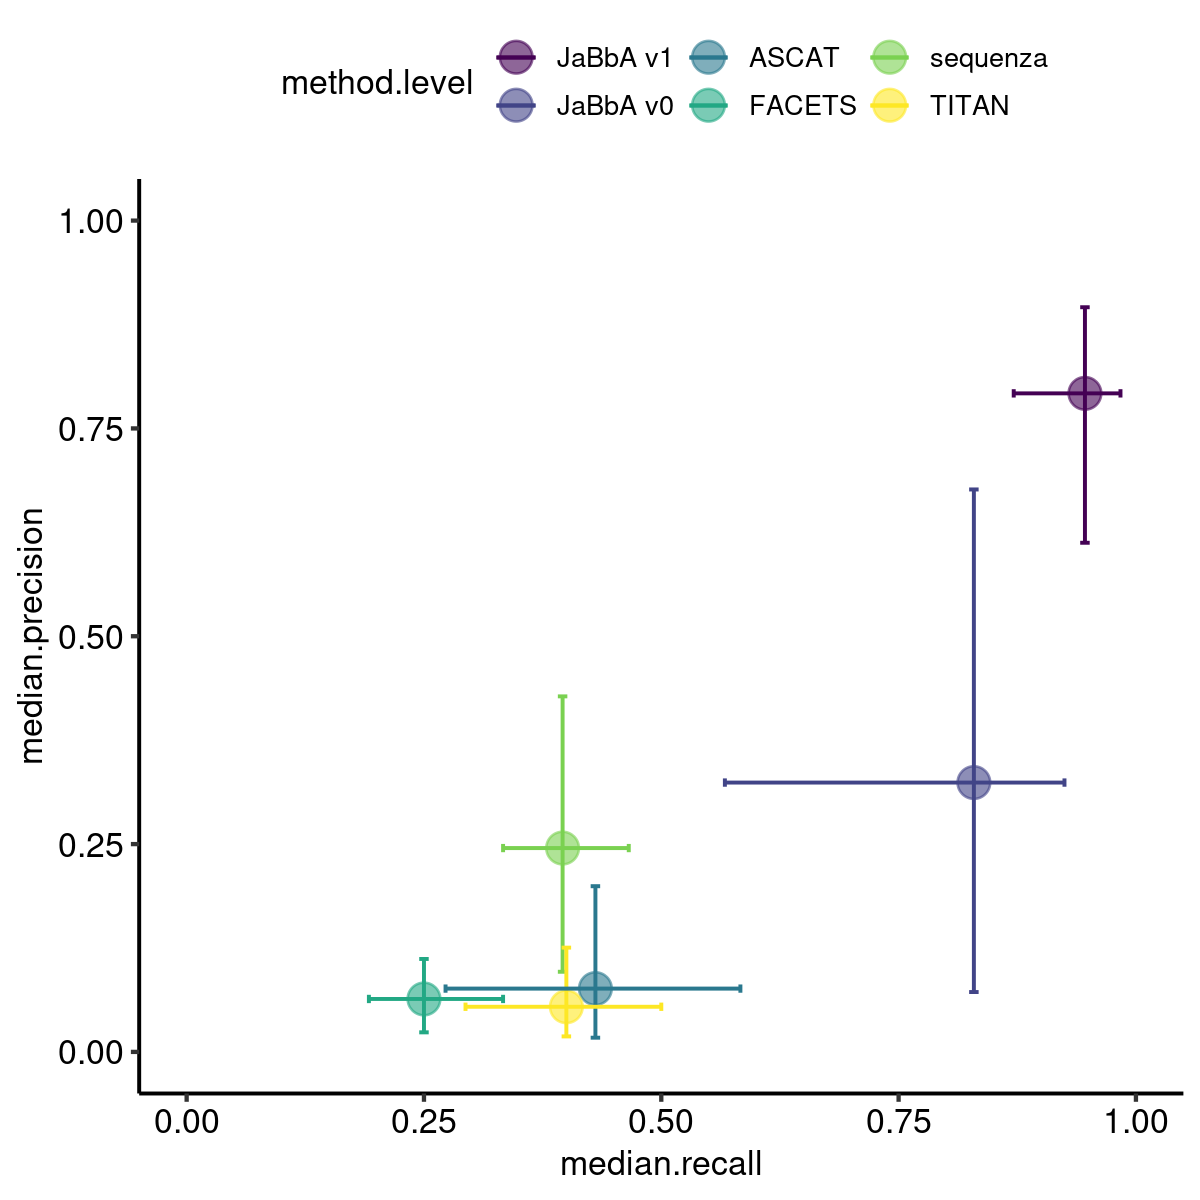

In [7]:
options(repr.plot.height = 6, repr.plot.width = 6, repr.plot.res = 200)
pt

## Fig. 1c
Correlation between loose end and junction breakend counts.

In [12]:
gg.pairs = readRDS("./data/sample.table.rds")

pt = ggplot(gg.pairs[(lambda_cohort) & !is.na(final_njuncs) & !is.na(final_nsomatic), 
                     .(final_njuncs, final_nsomatic)], 
            aes(x = final_njuncs * 2, y = final_nsomatic)) +
    geom_point(alpha = 0.5, size = 1) +
    geom_smooth(method = "lm", formula = y ~ x, mapping = aes(x = final_njuncs * 2, y = final_nsomatic)) +
    labs(x = "number of junction breakends", y = "number of loose ends") +
    geom_abline(slope = 1, intercept = 0) +
    scale_x_continuous(trans = "log1p", breaks = c(0, 1, 10, 100, 1000)) +
    scale_y_continuous(trans = "log1p", breaks = c(0, 1, 10, 100, 1000)) +
    ggpubr::theme_pubr() +
    ggpubr::stat_cor(method = "pearson", label.x = 0.5, label.y = 5)

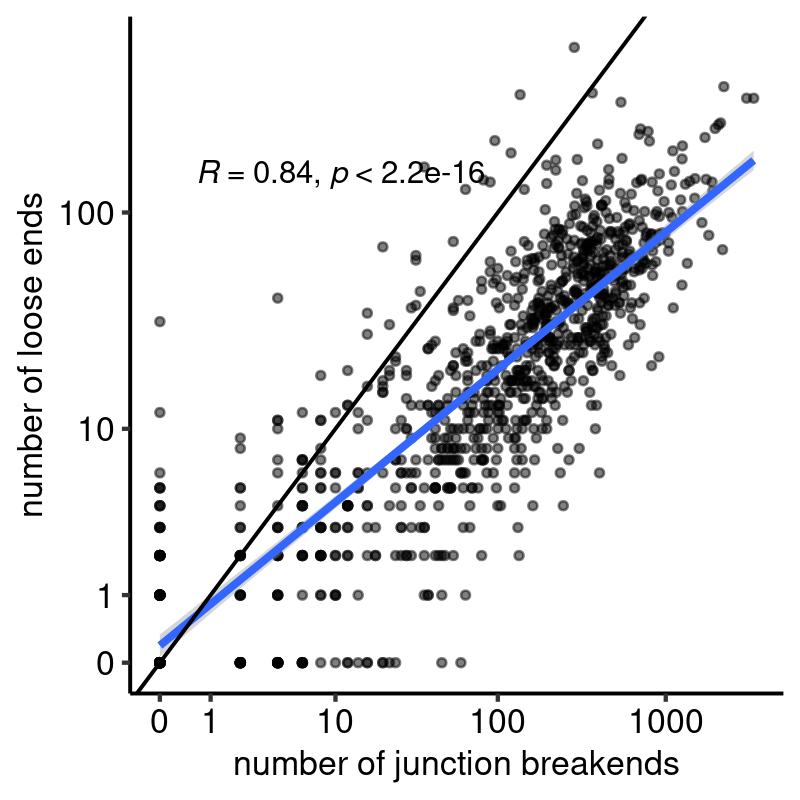

In [14]:
options(repr.plot.height = 4, repr.plot.width = 4, repr.plot.res = 200)
pt

## Fig. 1d
Junction counts versus loose end counts arranged by tumor type.

In [15]:
gg.pairs = readRDS("./data/sample.table.rds")

pt.dt = rbind(gg.pairs[(tn_cohort), .(pair, tumor_type_final, count = final_njuncs * 2, type = "junction")],
              gg.pairs[(tn_cohort), .(pair, tumor_type_final, count = final_nsomatic, type = "loose")])

pt.dt = pt.dt[!is.na(tumor_type_final)]

pt.dt[, sample := ordered(pair, levels = pt.dt[type == "junction"][order(count), pair])]
pt.dt[, label := ordered(tumor_type_final, levels = pt.dt[type == "junction"][, .(count = median(count)), by = tumor_type_final][order(count), tumor_type_final])]

pt = ggplot(pt.dt, aes(x = sample, y = count)) +
    facet_grid(rows = vars(type), cols = vars(label)) +
    geom_point(size = 0.01) +
    scale_y_continuous(trans = "log1p", breaks = c(0, 1, 10, 100, 1000)) +
    ggpubr::theme_pubr() +
    theme(axis.text.x = element_blank()) +
    theme(strip.text.x = element_text(angle = 90))

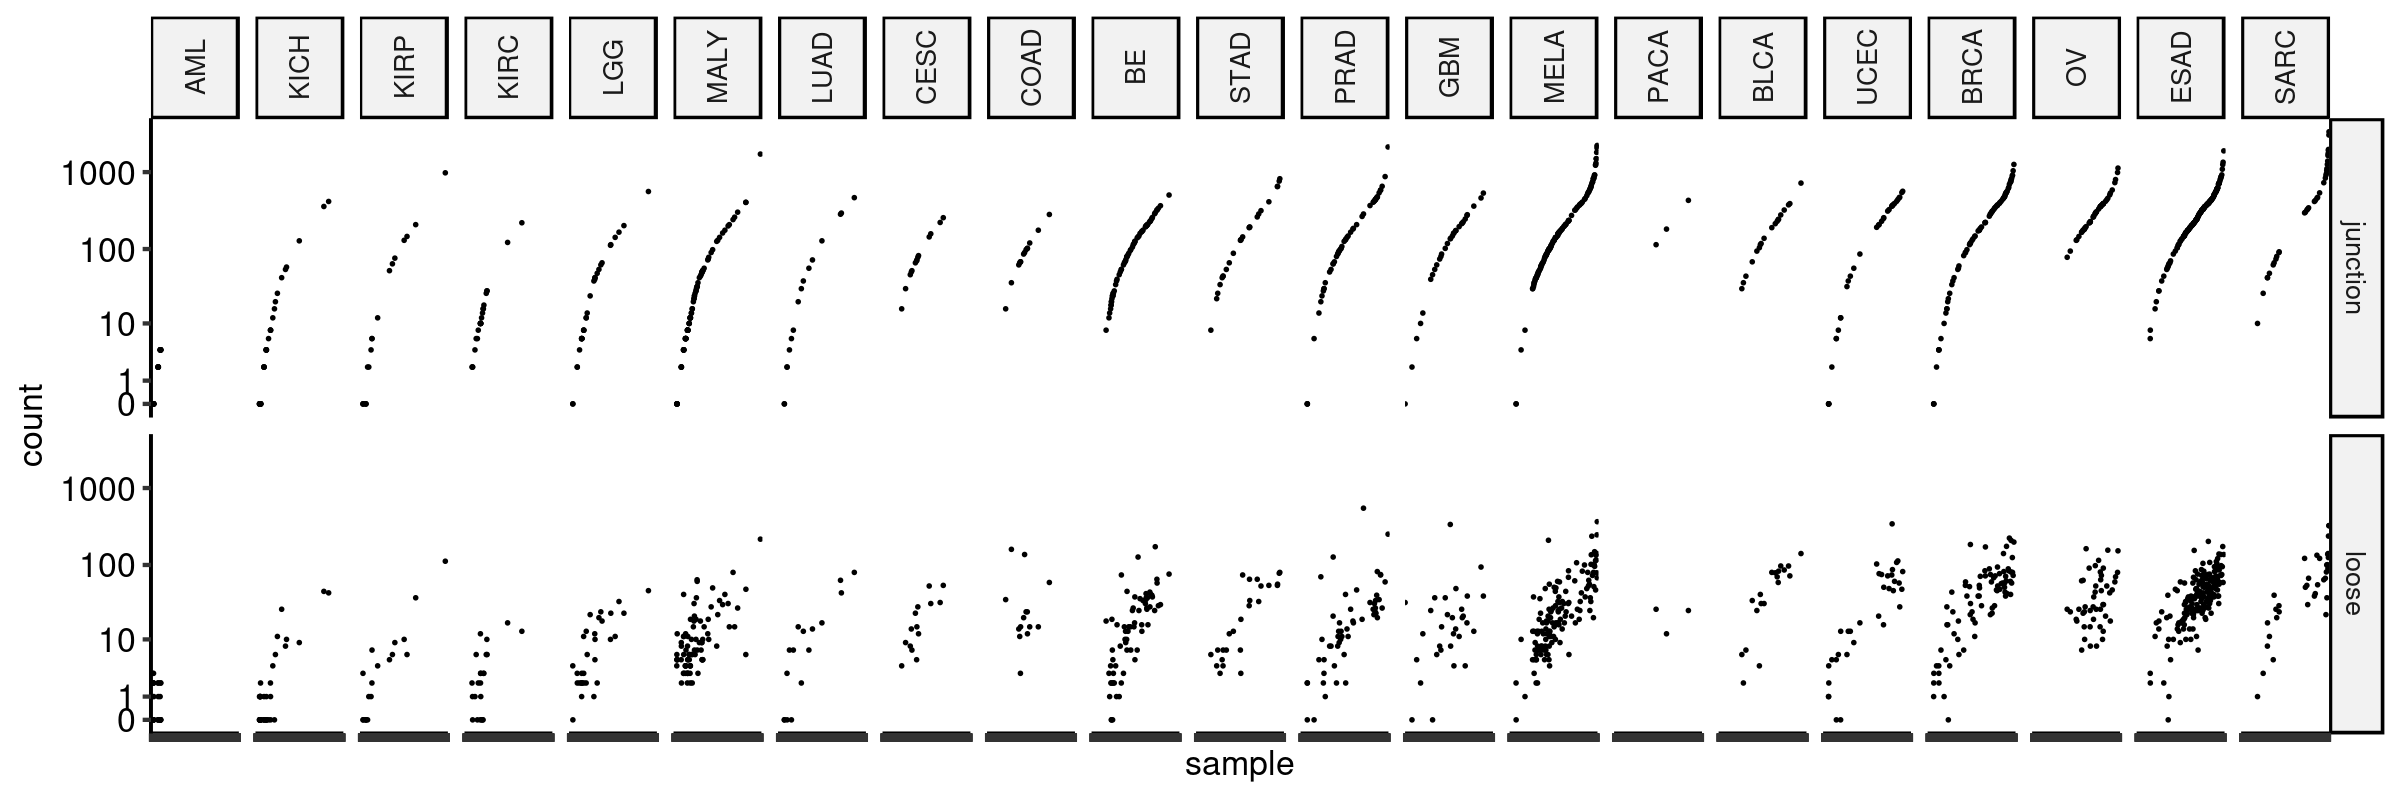

In [17]:
options(repr.plot.height = 4, repr.plot.width = 12, repr.plot.res = 200)
pt

## Fig. 1e
Proportion of breakends corresponding to junctions versus loose ends, and whether they are associated with SCNAs or copy neutral

In [20]:
all.bps.dt = readRDS("./data/all.bps.dt.rds")

two.by.two.dt = all.bps.dt[(two.by.two),
                           .N, 
                           by = .(loose.or.junction, balanced)]

two.by.two.dt[, balanced := ifelse(balanced, "balanced", "unbalanced")]
two.by.two.dt[, label := paste(loose.or.junction, balanced)][, frac := N / sum(N)]

two.by.two.dt[, col := c("pink", "red", "cornflowerblue", "navy")]

pt = ggplot(two.by.two.dt, aes(x = 1, y = N, fill = label)) + 
    geom_bar(stat = "identity") +
    scale_y_continuous(sec.axis = sec_axis(trans = ~ . / (two.by.two.dt[, sum(N)]), name = "frac")) +
    ggpubr::theme_pubr() +
    theme(legend.position = "right")

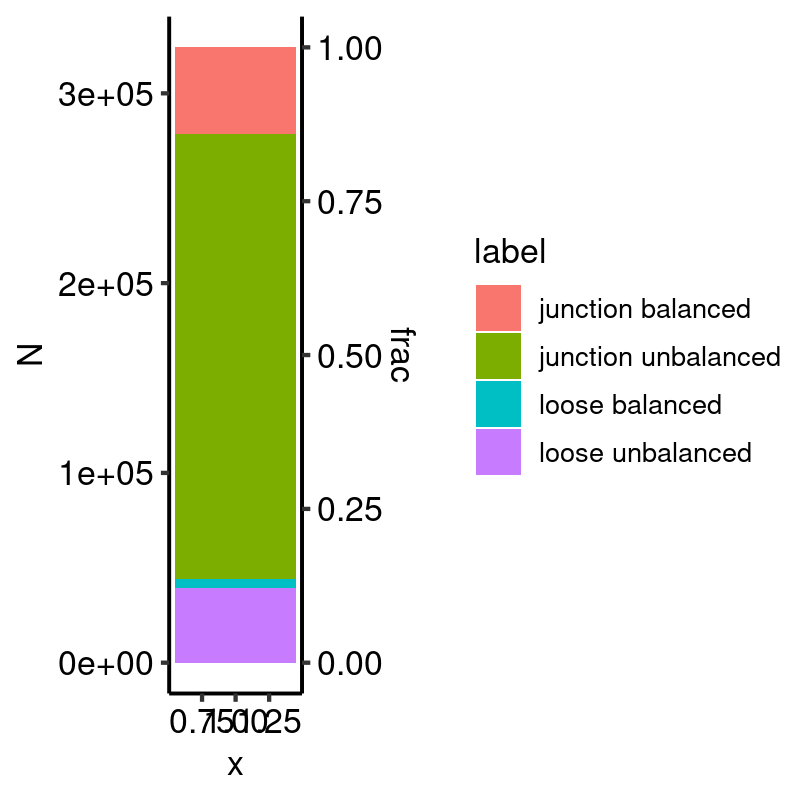

In [21]:
options(repr.plot.height = 4, repr.plot.width = 4, repr.plot.res = 200)
pt

# Figure 2
Loose end mappability and comparison with long molecule profiling (Nanopore sequencing)

## Fig. 2b
Enrichment of repetitive sequences near to loose ends.

In [52]:
base.unmappable.tiles = readRDS("./data/genome_info/base.unmappable.tiles.gr.rds")
subject.dt = readRDS("./data/sequence_context/loose.ends.and.random.sites.rds")

base.unmappable.alift.gr = gUtils::anchorlift(query = base.unmappable.tiles,
                                              subject = dt2gr(subject.gr),
                                              include.values = TRUE,
                                              window = 1e5)

base.unmappable.alift.dt = as.data.table(base.unmappable.alift.gr)
base.unmappable.alift.dt[, bin := easy.cut((start + end) / 2, start = -1e5, end = 1e5, step = 1e3)]
base.unmappable.alift.dt[, bin := as.numeric(as.character(bin))]
pt.dt = base.unmappable.alift.dt[, .(count = .N), by = .(bin, type)]
pt.dt[, norm.factor := .SD[(bin < -5e3 & bin > -4e4), mean(count, na.rm = TRUE)], by = .(type)]
pt.dt[, norm.n := count / norm.factor]
pt.dt = pt.dt[abs(bin) < 25e3]
pt.dt[, x := - bin]

pt = ggplot(pt.dt[type == "loose" | type == "random"], aes(x = x / 1e3, y = norm.n, color = type)) +
    geom_line(position = "identity", stat = "identity", size = 0.8) +
    labs(x = "distance from loose end (kbp)", y = "LINE") + theme_bw() +
    ggpubr::theme_pubr() +
    ylim(0, 3) +
    xlim(-25, 25)

Computing overlaps

Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 230 out-of-bound ranges located on sequences
  11, 12, 14, 17, 18, 19, 1, 22, 2, 5, 7, 8, X, 1_gl000192_random,
  19_gl000209_random, 20, 6, 4, Un_gl000221, 13, Un_gl000228,
  Un_gl000213, 16, 9_gl000198_random, 10, Un_gl000223, Un_gl000249,
  1_gl000191_random, 4_gl000193_random, Y, Un_gl000240, Un_gl000216,
  7_gl000195_random, 9_gl000199_random, Un_gl000220, Un_gl000219, 3,
  Un_gl000222, 21, Un_gl000227, 4_gl000194_random, Un_gl000218,
  17_gl000205_random, 8_gl000197_random, Un_gl000214, Un_gl000247, 15,
  Un_gl000236, Un_gl000244, 9_gl000200_random, Un_gl000215, Un_gl000225,
  Un_gl000217, 17_gl000203_random, 11_gl000202_random, Un_gl000237,
  17_gl000204_random, Un_gl000235, Un_gl000211, and 9. Note that ranges
  located on a sequence whose length is unknown (NA) or on a circular
  sequence are not considered out-of-bound (use seqlengths() and
  isCircular() to ge

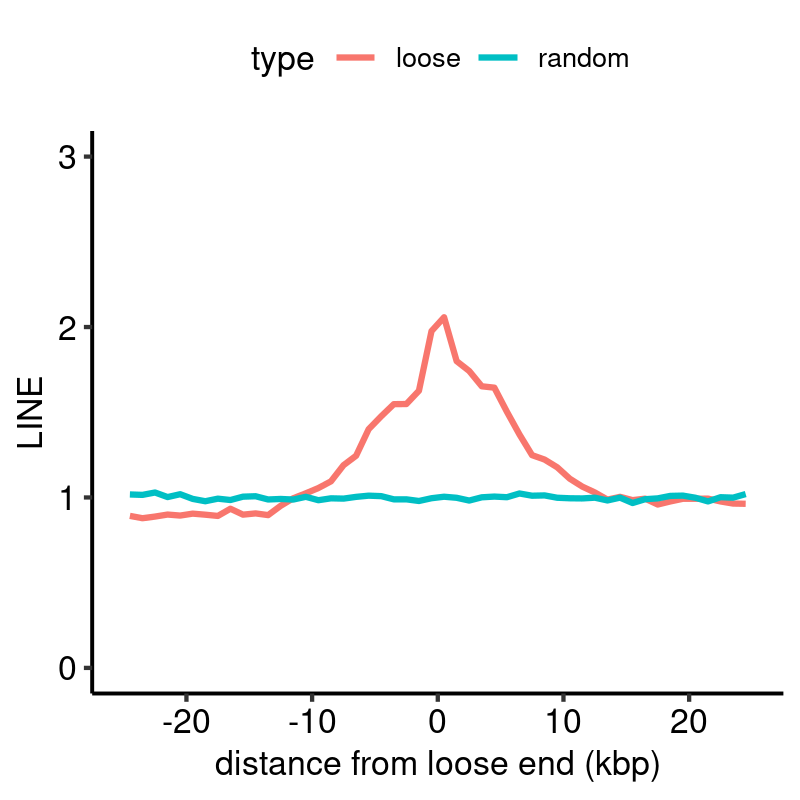

In [53]:
options(repr.plot.height = 4, repr.plot.width = 4, repr.plot.res = 200)
pt

## Fig. 2c
Density of loose reads (uniquely mapping reads with ambiguously mapping mates) near loose ends

In [54]:
## The raw data (positional reads) for this plot is *huge* 
## Consequently I only saved the summarized count of loose reads by position
pt.dt = readRDS("./data/sequence_context/loose.reads.overall.rds")

pt = ggplot(pt.dt[somatic == "somatic"], aes(x = x, y = norm.n, color = tumor)) +
    geom_line(size = 0.8) +
    facet_grid(rows = vars(read.strand)) +
    labs(x = "distance from loose end (bp)", y = "loose read density") +
    ggpubr::theme_pubr()

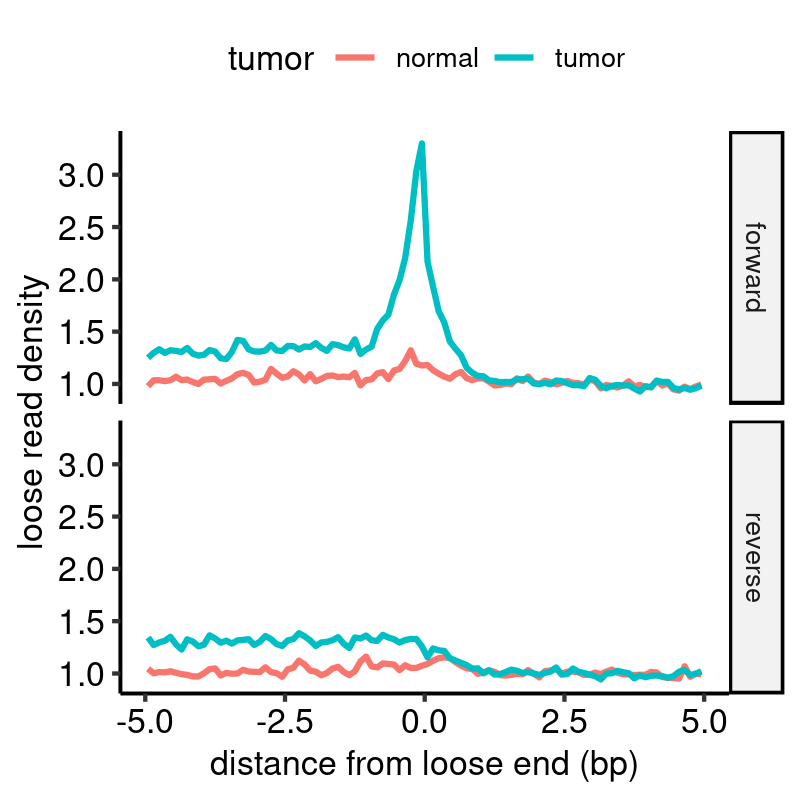

In [56]:
options(repr.plot.height = 4, repr.plot.width = 4, repr.plot.res = 200)
pt

## Fig. 2e
Alluvial plot of loose ends as fully, ambiguously, and partially mapped.

In [60]:
alluv.dt = readRDS("~/projects/gGnome/files/zc_stash/fig2.alluv.dt.rds")
all.bps.dt = readRDS("./data/all.bps.dt.rds")

alluv.pt = ggplot(alluv.dt, aes(axis1 = annotation.levels, axis3 = proximal.levels, axis2 = distal.levels, y = overall.frac)) +
    ggalluvial::geom_alluvium(aes(fill = annotation.levels), knot.pos = 0.3, width = 0, reverse = FALSE) +
    ggalluvial::geom_stratum(width = 0.4, reverse = FALSE, alpha = 0.5, color = "black") +
    scale_y_continuous(sec.axis = sec_axis(trans = ~ . * (all.bps.dt[(gg.pairs[sample, tn_cohort]) & (loose.or.junction == "loose"),.N]), 
                                           name = "count")) +
    geom_text(stat = "stratum", aes(label = after_stat(stratum)), reverse = FALSE, alpha = 1) +
    labs(y = "number of breakends") +
    coord_flip() +
    ggpubr::theme_pubr()

Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”


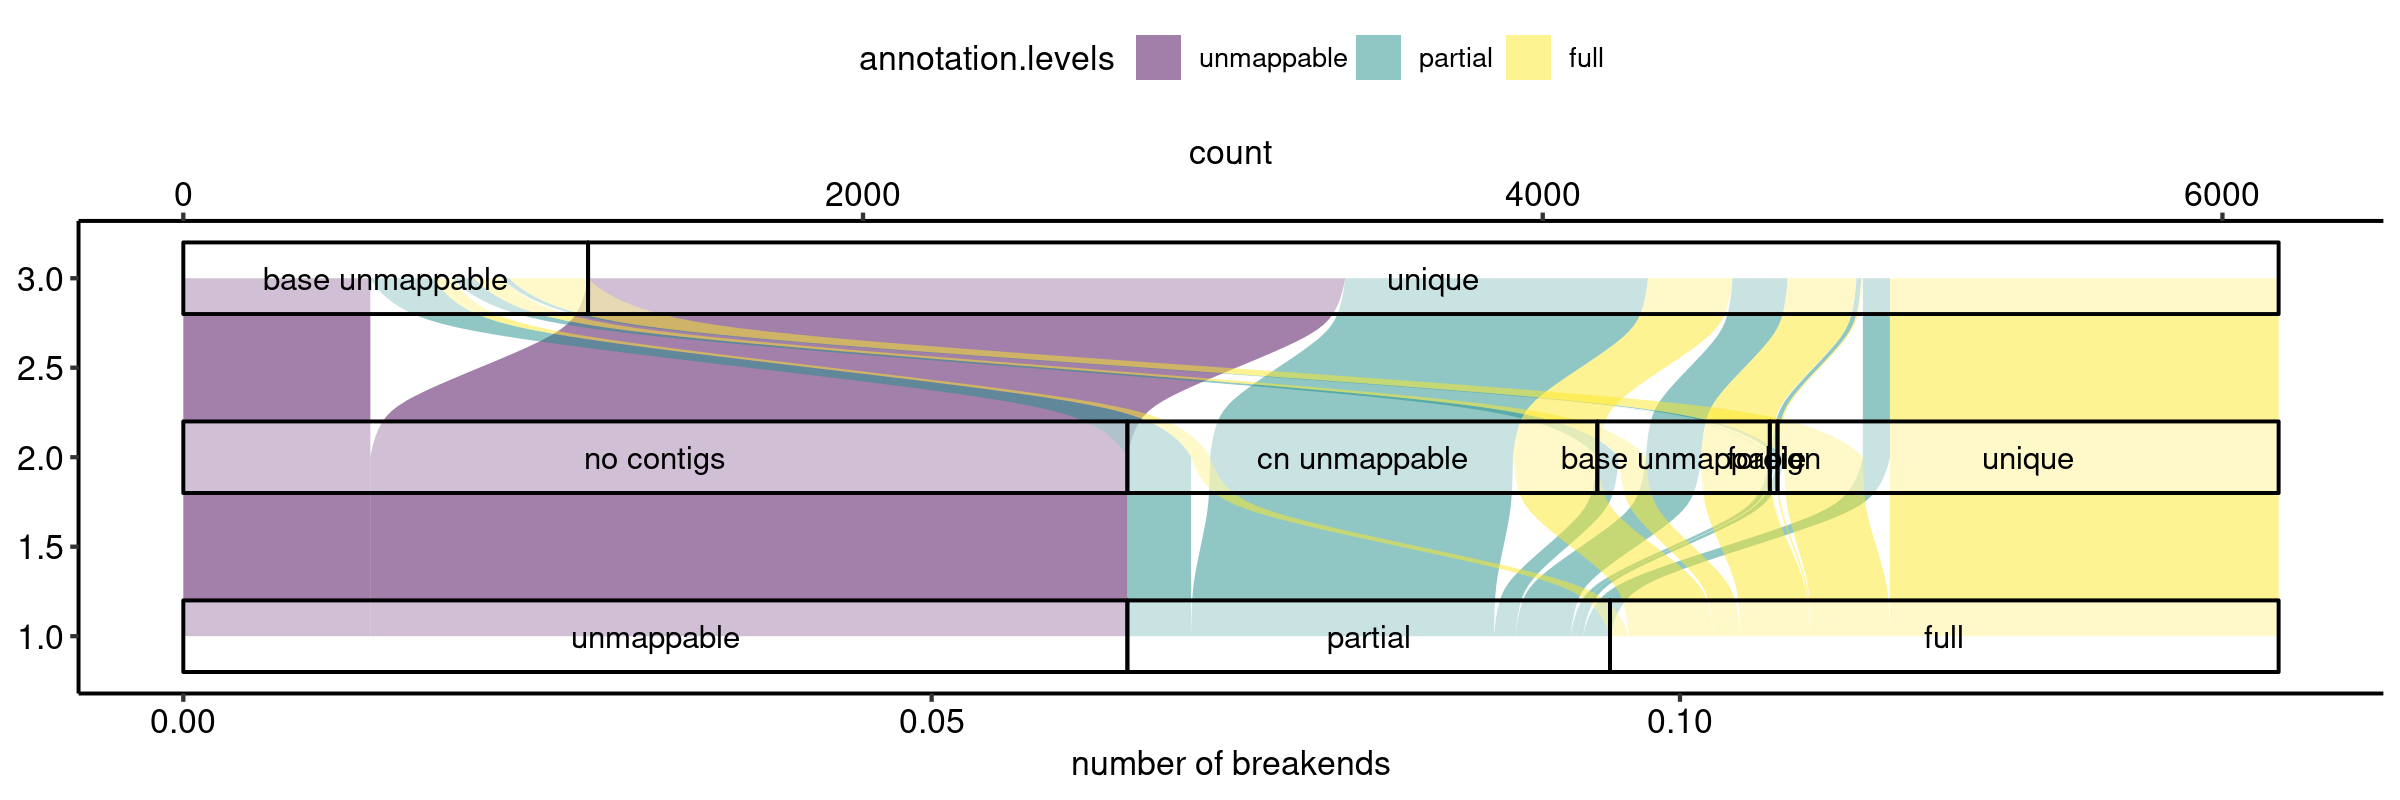

In [62]:
options(repr.plot.height = 4, repr.plot.width = 12, repr.plot.res = 200)
alluv.pt

## Fig. 2F
Comparison of breakends between short reads and nanopore sequencing, depending on whether a breakend has a reciprocal rearrangement.

In [63]:
## this file contains the raw data (breakend locations) for the alluvial plot
## however, reading it isn't necessary if you just want to produce the alluvial plot
ont.bps.dt = readRDS("./data/ont/ont.bps.dt.rds")

,size,isdir,mode,mtime,ctime,atime,uid,gid,uname,grname
,<dbl>,<lgl>,<octmode>,<dttm>,<dttm>,<dttm>,<int>,<int>,<chr>,<chr>
~/projects/gGnome/files/zc_stash/ont.bps.dt.rds,104047,FALSE,664,2023-02-22 08:12:45,2023-02-22 08:12:45,2023-02-20 16:06:04,50968,10331,zchoo,milab


In [64]:
alluv.dt = readRDS("./data/ont/ont.alluv.dt.rds")

alluv.pt = ggplot(alluv.dt, aes(axis1 = intersection.label, axis2 = reciprocal.label, y = N)) +
    ggalluvial::geom_alluvium(aes(fill = intersection.label), knot.pos = 0.3, width = 0, reverse = FALSE) +
    ggalluvial::geom_stratum(width = 0.1, reverse = FALSE, alpha = 1, color = "white", fill = "white") +
    scale_y_continuous(sec.axis = sec_axis(trans = ~ . / (alluv.dt[, sum(N)]), name = "frac")) +
    geom_text(stat = "stratum", aes(label = after_stat(stratum)), reverse = FALSE, alpha = 1) +
    labs(y = "count") +
    ggpubr::theme_pubr() +
    theme(legend.position = "none")

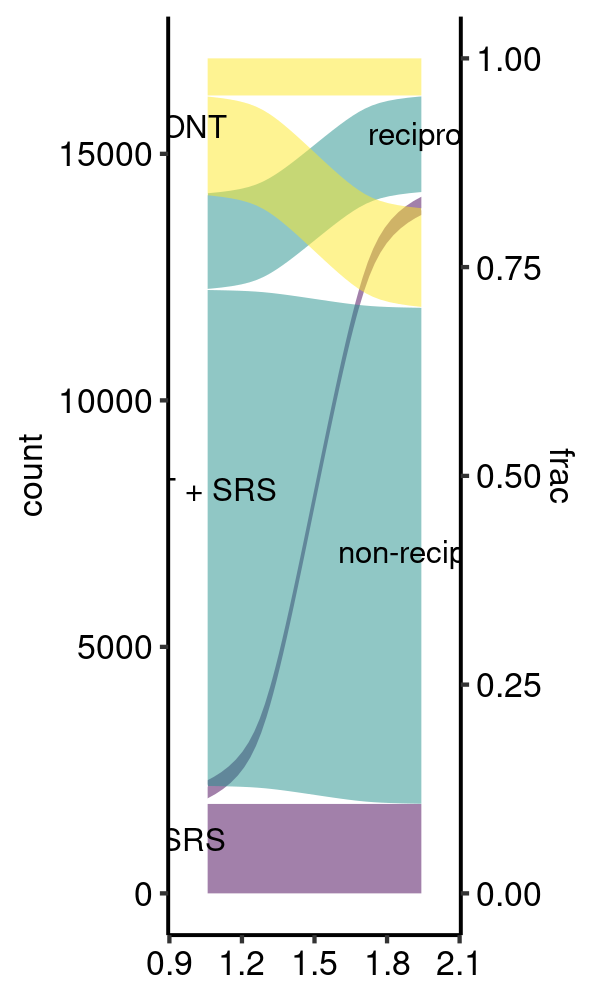

In [67]:
options(repr.plot.height = 5, repr.plot.width = 3, repr.plot.res = 200)
alluv.pt

## Fig. 2g
Comparison of complex event calls between short reads and ONT

In [68]:
## event calls
ont.rescue.events.dt = readRDS("./data/ont/ont.rescue.events.dt.rds")

## sample table
ont.pairs = readRDS("./data/ont/ont.sample.table.rds")

ont.rescue.events.dt = ont.rescue.events.dt[(ont.pairs[sample, (ont_cohort)]),]
valid.etypes = c("del", "dup", "inv", "tra", "invdup", "pyrgo", "rigma", "chromoplexy", "chromothripsis", "complex amplicon", "tic")
amplicon.etypes = c("bfb", "dm", "cpxdm", "tyfonas")
ont.rescue.per.event.dt = ont.rescue.events.dt[, .(old = old[1],
                                                   type = type[1],
                                                   fp = paste(paste0(seqnames, ":", start, "-", end,"+"),
                                                              collapse = ",")),
                                               by = .(ev.id, sample)]
ont.rescue.per.event.dt[, new.etype := ifelse(type %in% amplicon.etypes, "complex amplicon", type)]

ont.frac.event.dt = ont.rescue.per.event.dt[(new.etype %in% valid.etypes),]
ont.frac.event.dt[, new.label := ordered(ifelse(old, "SRS only", "LRS + SRS"), levels = c("SRS only", "LRS + SRS"))]
ont.frac.event.dt[, nice.labels := paste(new.etype, paste0("(", .N, ")")), by = new.etype]
label.order = ont.frac.event.dt[, .N, by = nice.labels][order(N), nice.labels]
ont.frac.event.dt[, label.levels := ordered(nice.labels, levels = label.order)]

## relevel...
ont.frac.event.dt[, complex := !(type %in% c("dup", "del", "inv", "tra", "invdup"))]
ont.frac.event.dt[, label.levels := ordered(nice.labels, 
                                            levels = ont.frac.event.dt[, .(complex = any(complex), 
                                                                           n = length(unique(paste(sample, ev.id)))), 
                                                                       by = nice.labels][order(n),][order(complex),][, nice.labels])]

bp = ggplot(ont.frac.event.dt, aes(x = label.levels, fill = new.label)) +
    geom_bar(stat = "count", position = "fill") +
    labs(x = "event type (n events)", y = "count") +
    ggpubr::theme_pubr() +
    coord_flip() +
    theme(legend.position = "right")


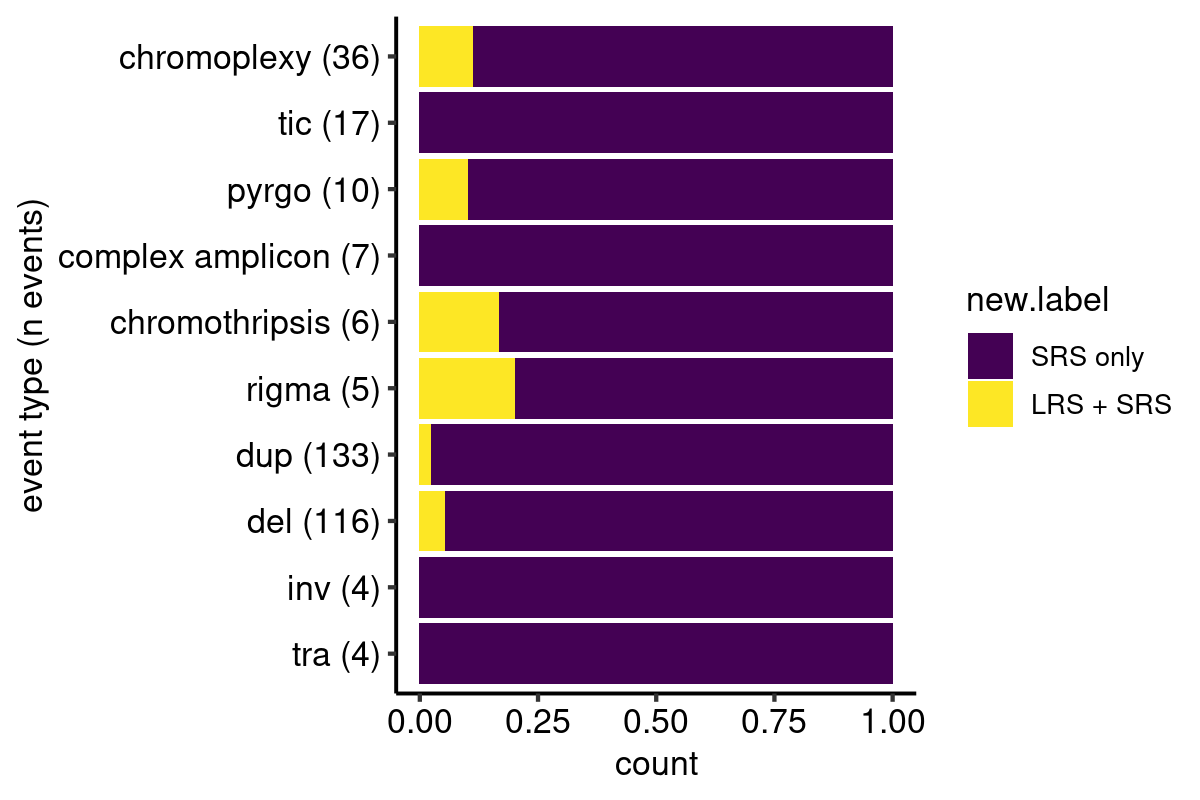

In [71]:
options(repr.plot.height = 4, repr.plot.width = 6, repr.plot.res = 200)
bp

# Figure 3
Analysis of TR+ loose ends and neotelomeres

## Fig. 3a
Anchorlift of telomeric loose reads over to somatic loose ends

In [72]:
## again, raw data file is gigantic!!
## just the trace for the anchorlift is saved.
pt.dt = readRDS("./data/neotelomeres/tr.loose.reads.anchorlift.rds")

pt = ggplot(pt.dt[somatic == "somatic"], aes(x = x, y = norm.n, color = tumor)) +
    geom_line(size = 0.8) +
    facet_grid(rows = vars(forward)) +
    labs(x = "distance from loose end (Kbp)", y = "telomeric loose reads") +
    ggpubr::theme_pubr()

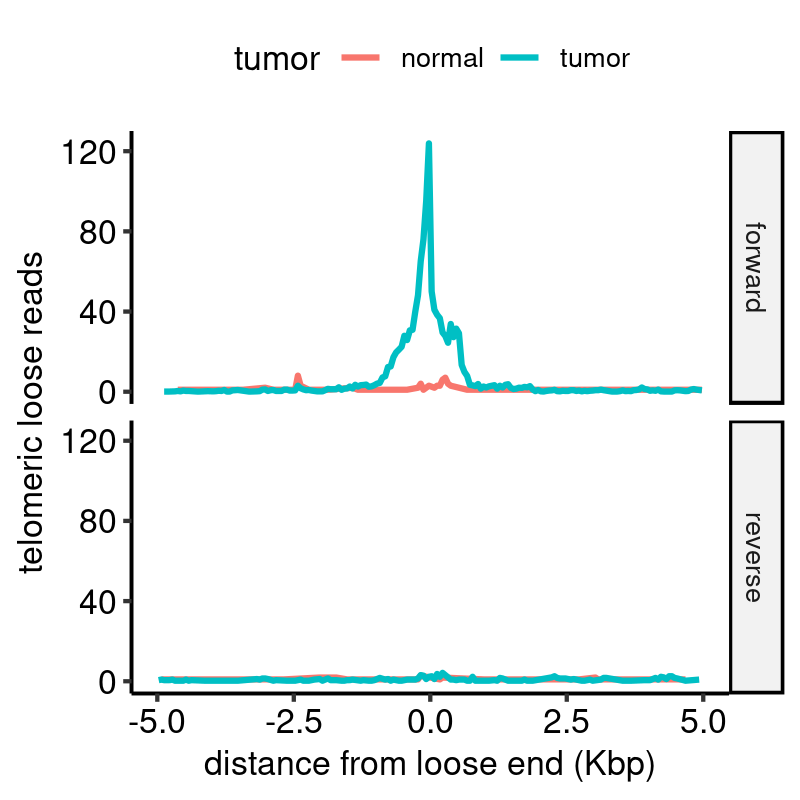

In [73]:
options(repr.plot.height = 4, repr.plot.width = 4, repr.plot.res = 200)
pt

## Fig. 3c
CRTR+ and GRTR+ telomeric loose reads vs. CRTR+ and GRTR+ loose ends

In [74]:
pt.dt = readRDS("./data/neotelomeres/crtr.grtr.loose.reads.anchorlift.rds")

pt = ggplot(pt.dt[tumor == "tumor"], aes(x = bin, y = n, color = color.label)) + 
geom_line(size = 1, alpha = 0.5) + 
facet_grid(rows = vars(forward), cols = vars(rep)) + 
labs(x = "distance from loose end (bp)", y = "telomeric loose reads") + 
ggpubr::theme_pubr()

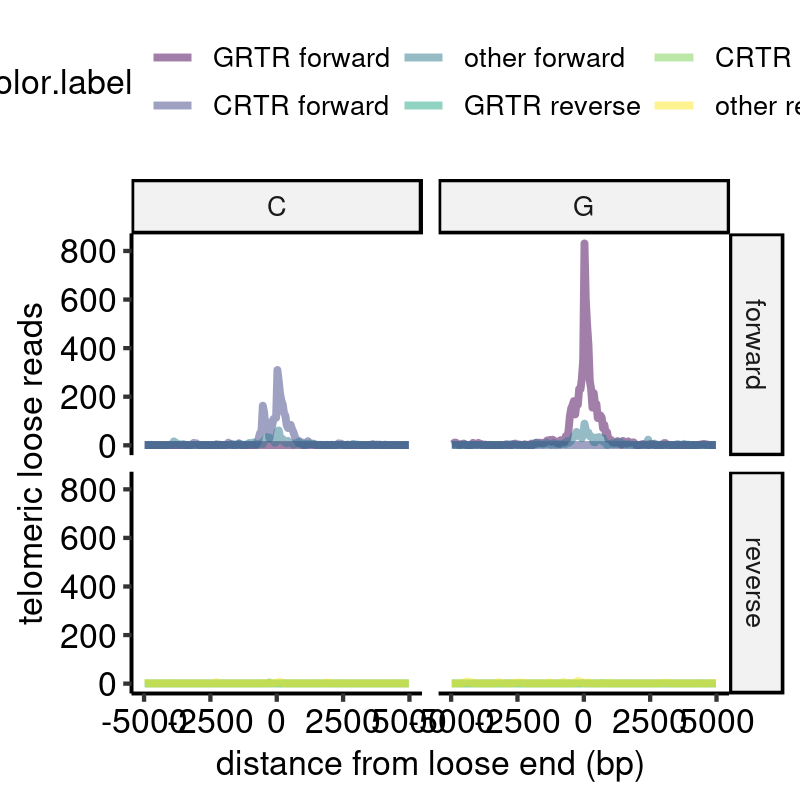

In [75]:
options(repr.plot.height = 4, repr.plot.width = 4, repr.plot.res = 200)
pt

## Fig. 3d
Anchorlift telomeric bmates to loose ends in linked reads profiles (sLRS)

In [78]:
all.treads.dt = readRDS("./data/neotelomeres/lrs.all.telomeric.reads.for.anchorlift.dt.rds")
all.telo.bnds.dt = readRDS("./data/neotelomeres/lrs.all.telomeric.breakends.for.anchorlift.dt.rds")

## anchorlift anchorlift
telo.alift.dt = gUtils::anchorlift(query = dt2gr(all.treads.dt),
                                   subject = dt2gr(all.telo.bnds.dt) %>% gr.flipstrand,
                                   by = c("type", "sample"),
                                   window = 1e7) %>% as.data.table

## binning and normalization
telo.alift.dt[, bin := easy.cut(start, start = -5e5, step = 1e4)]
telo.alift.dt[, bin := as.numeric(as.character(bin))]
pt.dt = telo.alift.dt[!is.na(bin), .(n = .N), by = .(bin, type)][!is.na(bin)]
pt.dt[, norm.factor := .SD[(bin > 0 & bin < 5e4), mean(n, na.rm = TRUE)], by = type]
pt.dt[, norm.n := n / norm.factor]
pt.dt[, x := bin / 1e3]

pt = ggplot(pt.dt, aes(x = x, y = norm.n, color = type)) +
    geom_line(size = 1, alpha = 0.8) +
    labs(x = "distance from loose end (kbp)", y = "normalized bmate count") +
    ggpubr::theme_pubr() +
    ylim(0, 25) +
    xlim(-250, 250) +
    theme(legend.position = "bottom")

Warning message in .normarg_strand(strand, seqnames):
“missing values in 'strand' converted to "*"”
Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 12123 out-of-bound ranges located on sequence
  *. Note that ranges located on a sequence whose length is unknown (NA)
  or on a circular sequence are not considered out-of-bound (use
  seqlengths() and isCircular() to get the lengths and circularity flags
  of the underlying sequences). You can use trim() to trim these ranges.
  See ?`trim,GenomicRanges-method` for more information.”
Computing overlaps

Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 43 out-of-bound ranges located on sequences 22,
  9, 12, 14, 18, 19, 1, 21, 4, X, 11, 13, 2, 3, 6, 7, 10, 15, 17, 20, 5,
  16, and 8. Note that ranges located on a sequence whose length is
  unknown (NA) or on a circular sequence are not considered out-of-bound
  (use seqlengths() and isCircular()

Warning message:
“Removed 63 rows containing missing values (`geom_line()`).”


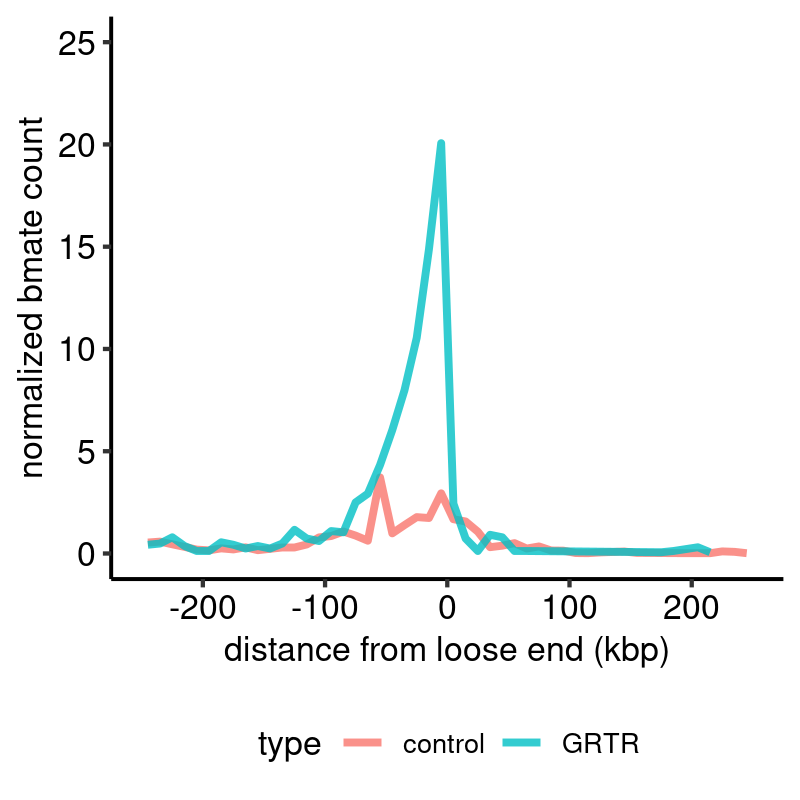

In [79]:
options(repr.plot.height = 4, repr.plot.width = 4, repr.plot.res = 200)
pt

## Fig. 3e
Distal fusion rate of GRTR+ versus CRTR+ loose ends in linked read profiles (sLRS)

In [80]:
lrs.calls.dt =  readRDS("./data/linked_reads/lrs.rescue.calls.dt.rds")
lrs.loose.dt = readRDS("./data/linked_reads/lrs.rescue.loose.dt.rds")

lrs.calls.dt[, new.annotation := ifelse(somatic == "somatic", annotation, "no contigs")]
lrs.calls.dt[, keep := lrs.loose.dt[lrs.calls.dt, keep]]
lrs.calls.dt[, lrs := lrs.loose.dt[lrs.calls.dt, linkedsv]]
lrs.calls.dt[, label := ifelse(g_telomeric, "GRTR", ifelse(c_telomeric, "CRTR", "other"))]
lrs.calls.dt[is.na(label), label := "other"]

bp.dt = lrs.calls.dt[, .(n.lrs = sum(lrs, na.rm = TRUE), 
                         n.samples = .N, frac = sum(lrs, na.rm = TRUE) / .N), 
                     by = label]
bp.dt[, ci.lower := unlist(mapply(function(x,y) {dflm(prop.test(x, y))$ci.lower}, n.lrs, n.samples))]
bp.dt[, ci.upper := unlist(mapply(function(x,y) {dflm(prop.test(x, y))$ci.upper}, n.lrs, n.samples))]

bp.dt[, paper.factors := ordered(label, levels = c("GRTR", "CRTR", "other"))]

bp = ggplot(bp.dt, aes(x = paper.factors, y = frac)) + 
geom_errorbar(mapping = aes(ymin = ci.lower,ymax = ci.upper), 
              width = 0.2, position = position_dodge(0.9)) + 
geom_bar(stat = "identity") + 
labs(x = "loose end type", y = "fraction rescued") + 
ggpubr::theme_pubr()




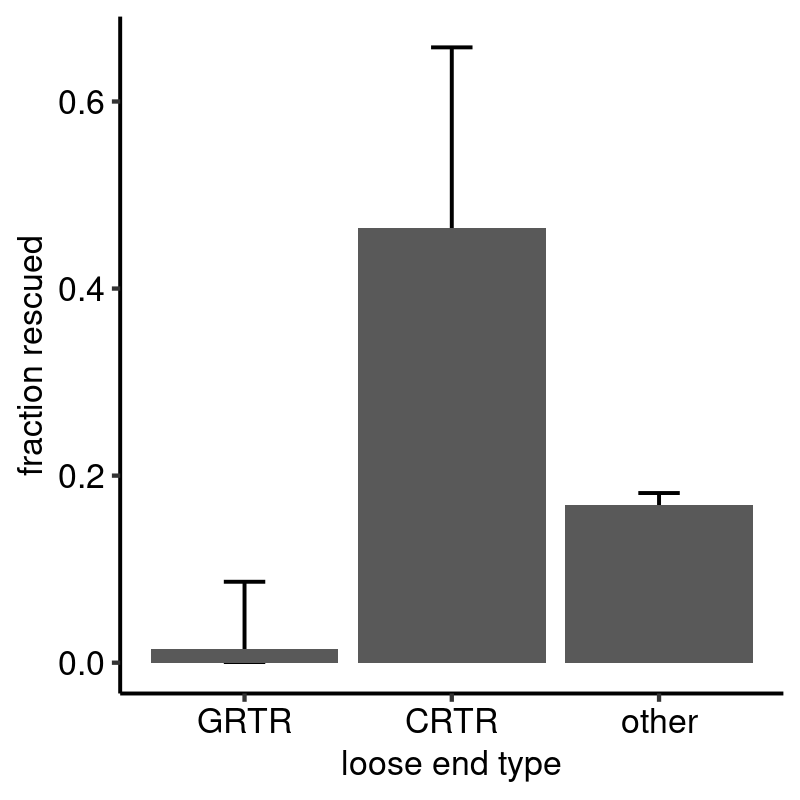

In [81]:
options(repr.plot.height = 4, repr.plot.width = 4, repr.plot.res = 200)
bp

In [82]:
telo.pt.dt = readRDS("./data/neotelomeres/neotelomeres.length.estimation.dt.rds")

pt = ggplot(telo.pt.dt[tlength < 1e5], aes(x = category, y = log10(tlength + 1))) +
    scale_y_continuous(breaks = c(0, 1, 2, 3, 4)) +
    geom_boxplot(width = 0.3, outlier.shape = NA) +
    labs(y = "telomere length - log(bp + 1)", x = "category") + 
    ggpubr::theme_pubr()

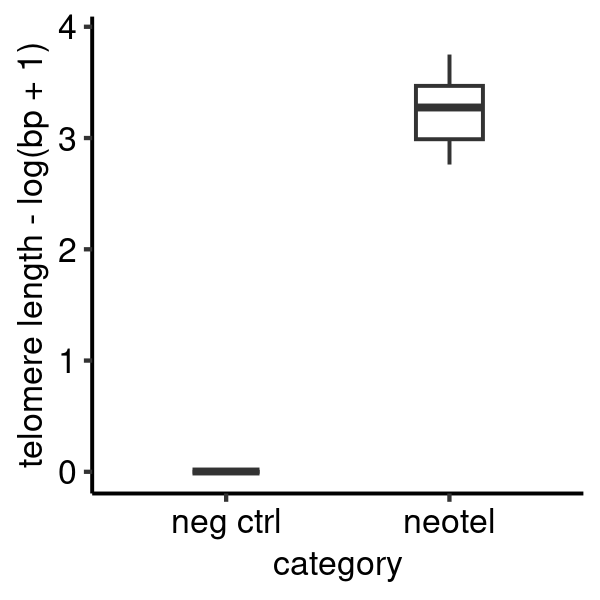

In [84]:
options(repr.plot.height = 3, repr.plot.width = 3, repr.plot.res = 200)
pt

## Fig. 3j
Association between presence of GRTR+ loose ends vs. mutation and expression of ATRX and TERT

In [85]:
bp.frac.dt = readRDS("./data/neotelomeres/figure.3g.atrx.telomerase.crtr.grtr.bp.dt.rds")
fisher.test.dt = readRDS("./data/neotelomeres/figure.3g.atrx.telomerase.crtr.grtr.fisher.test.rds")

pt = ggplot(bp.frac.dt, aes(x = x, y = frac, fill = x)) +
    geom_bar(stat = "identity") +
    facet_grid(cols = vars(column.name), rows = vars(row.name)) +
    geom_errorbar(mapping = aes(ymin = ci.lower,ymax = ci.upper), width = 0.2, position = position_dodge(0.9)) +
    ggpubr::stat_pvalue_manual(data = fisher.test.dt, y.position = 0.75, label = "stars") +
    ggpubr::theme_pubr() +
    ylim(0, 1) +
    theme(legend.position = "none")

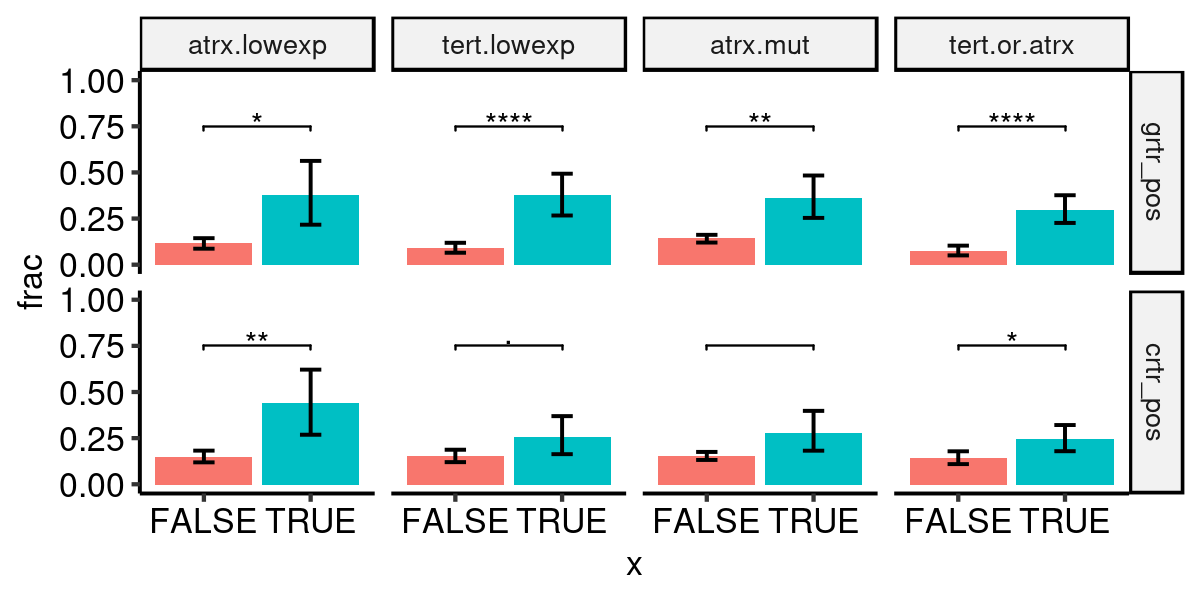

In [87]:
options(repr.plot.height = 3, repr.plot.width = 6, repr.plot.res = 200)
pt

In [88]:
## the same plot but just with GRTR+ loose ends
## which is what's in the actual paper
pt = ggplot(bp.frac.dt[row.name == "grtr_pos"], aes(x = x, y = frac, fill = x)) +
    geom_bar(stat = "identity") +
    facet_grid(cols = vars(column.name)) +
    geom_errorbar(mapping = aes(ymin = ci.lower,ymax = ci.upper), width = 0.2, position = position_dodge(0.9)) +
    ggpubr::stat_pvalue_manual(data = fisher.test.dt, y.position = 0.75, label = "stars") +
    ggpubr::theme_pubr() +
    ylim(0, 1) +
    theme(legend.position = "none")

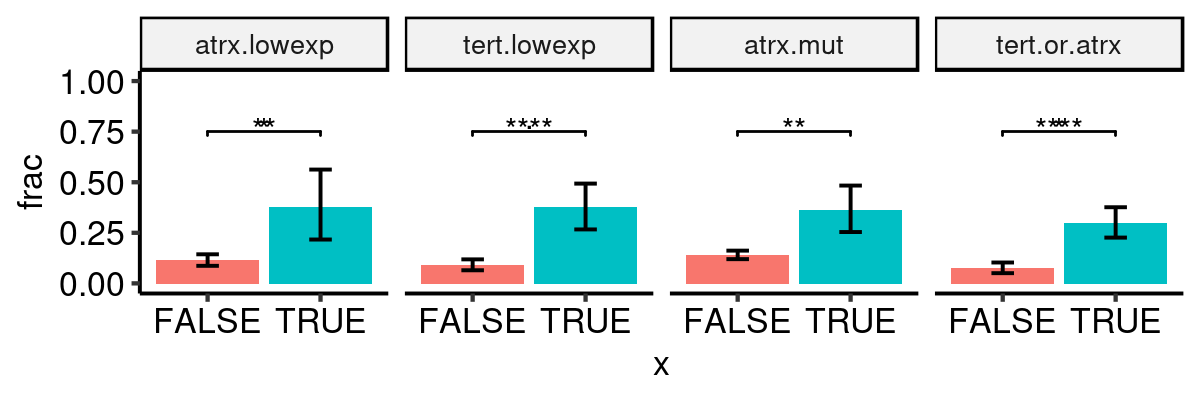

In [89]:
options(repr.plot.height = 2, repr.plot.width = 6, repr.plot.res = 200)
pt

## Fig. 3k
Association between GRTR+ loose ends and tumor type

In [91]:
tr.tt.glm.dt = readRDS("./data/neotelomeres/tr.tumor.type.glm.dt.rds")

tr.tt.glm.dt[, p.adj := p.adjust(p, method = "bonferroni")]
tr.tt.glm.dt[, log.odds := log2(estimate)]
tr.tt.glm.dt[, log.p := -log10(p)]
tr.tt.glm.dt[, label := ifelse(abs(log.odds) > 1 & -log10(p.adj) > 1, tumor_type_final, "")]
tr.tt.glm.dt[, color := ifelse(abs(log.odds) > 1 & -log10(p.adj) > 1, "red", "gray")]

pt = ggplot(tr.tt.glm.dt, aes(x = log.odds, y = log.p)) +
    geom_point(size = 0.6, aes(color = color)) +
    ggrepel::geom_label_repel(aes(label = label), box.padding = 0.15, point.padding = 0.1, segment.color = 'grey50', max.overlaps = 10) +
    labs(x = "fold change", y = "-logp", title = "tumor type") +
    geom_vline(xintercept = 1, linetype = "dashed", size = 0.5) +
    geom_vline(xintercept = -1, linetype = "dashed", size = 0.5) +
    geom_hline(yintercept = -log10(0.05), linetype = "dashed", size = 0.5) +
    theme_bw() +
    xlim(-5, 5) + ylim(0, 10) +
    scale_color_identity() +
    facet_grid(cols = vars(type)) +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())

Warning message:
“Removed 3 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 3 rows containing missing values (`geom_label_repel()`).”


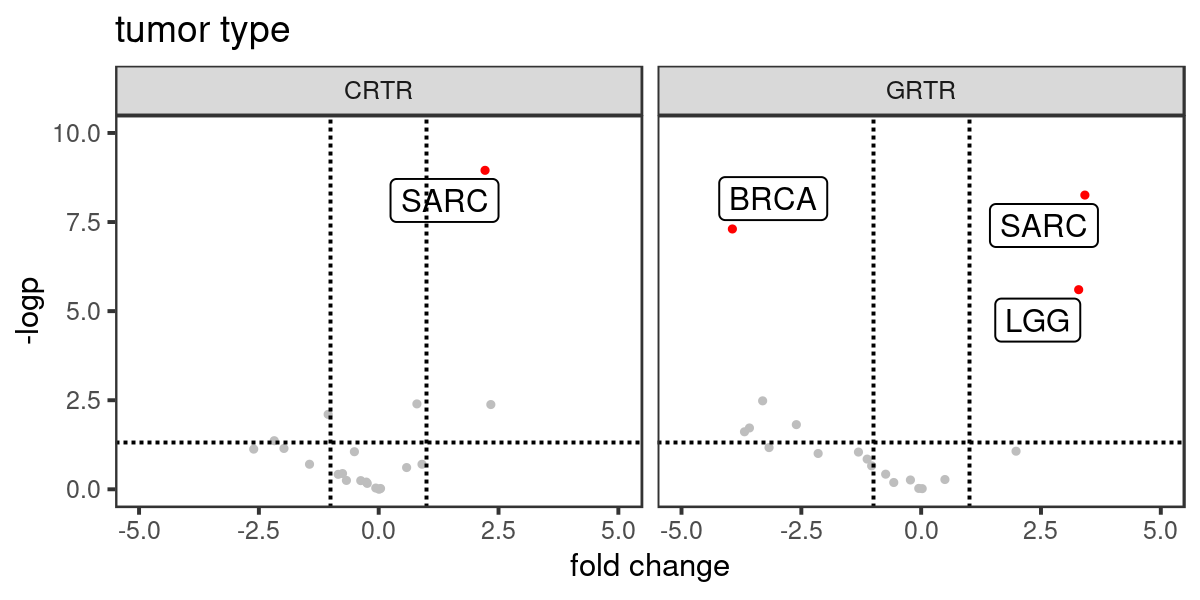

In [93]:
options(repr.plot.height = 3, repr.plot.width = 6, repr.plot.res = 200)
pt

## Fig. 3l
Event type associations of CRTR+ and GRTR+ loose ends

In [96]:
tr.ev.glm.dt = readRDS("./data/neotelomeres/tr.events.glm.dt.co_occur.rds")

pt = ggplot(tr.ev.glm.dt, aes(x = log.odds, y = log.p)) +
    geom_point(size = 0.6, aes(color = color)) +
    ggrepel::geom_label_repel(aes(label = label), box.padding = 0.15, point.padding = 0.1, segment.color = 'grey50', max.overlaps = 10) +
    labs(x = "fold change", y = "-logp", title = "complex SV event type") +
    geom_vline(xintercept = 1, linetype = "dashed", size = 0.5) +
    geom_vline(xintercept = -1, linetype = "dashed", size = 0.5) +
    geom_hline(yintercept = -log10(0.05), linetype = "dashed", size = 0.5) +
    theme_bw() +
    xlim(-3, 3) + ylim(0, 12) +
    scale_color_identity() +
    facet_grid(cols = vars(type)) +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())

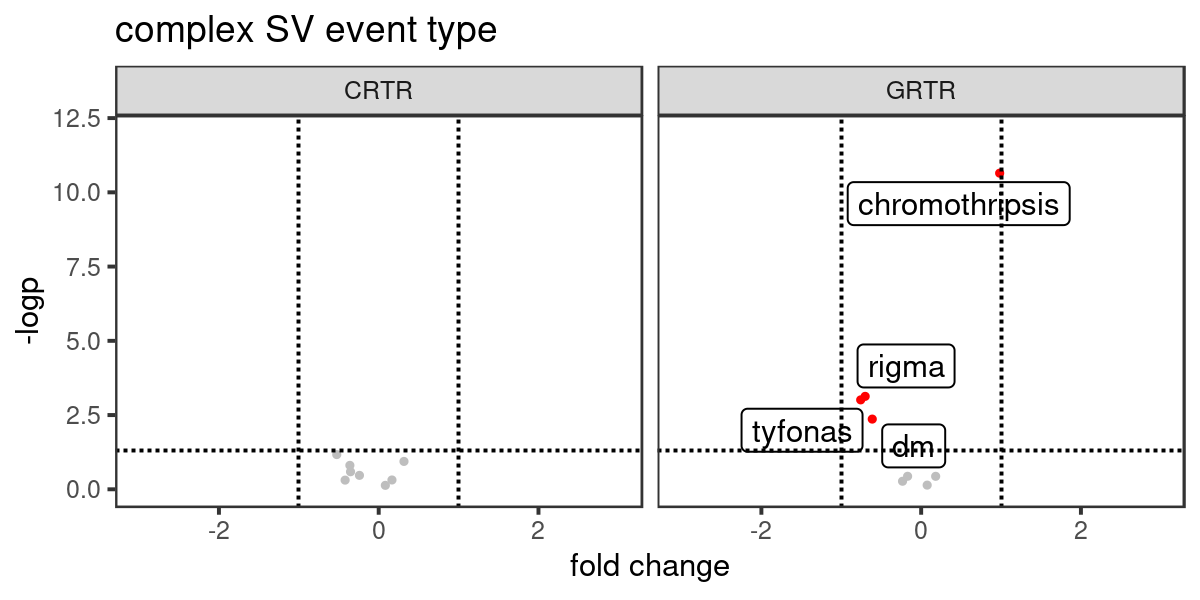

In [97]:
options(repr.plot.height = 3, repr.plot.width = 6, repr.plot.res = 200)
pt

# Figure 4
Structural variants generated by aberrant homologous recombination repair.

## Fig. 4c
Segment width associated with copy neutral LOH due to mitotic recombination

In [129]:
cnloh.ranges = readRDS("./data/cnloh/cnloh.ranges.rds")
loh.ranges = readRDS("./data/cnloh/loh.ranges.rds")
fake.cnloh.ranges = readRDS("./data/cnloh/fake.cnloh.ranges.rds") ## this is just "segmental UPD"

## convert to Kbp
cnloh.width.per.segment = cnloh.ranges[, .(width.kbp = width / 1e3)]
loh.width.per.segment = loh.ranges[, .(width.kbp = width / 1e3)]
fake.cnloh.width.per.segment = fake.cnloh.ranges[, .(width.kbp = width / 1e3)]

## merge these by sample
pt.dt = rbind(cnloh.width.per.segment[, type := "cnloh"],
              fake.cnloh.width.per.segment[, type := "upd"],
              loh.width.per.segment[, type := "loh"],
              fill = TRUE)

pt.dt[, type.level := ordered(type, levels = c("cnloh", "upd", "loh"))]

vp = ggplot(pt.dt, aes(y = width.kbp, x = type.level, fill = type.level)) +
    geom_violin(trim = FALSE, scale = "width", color = "white", size = 0.1) +
    labs(x = "", y = "width (Mbp)", title = "CNLOH width per sample") +
    geom_boxplot(width = 0.1, outlier.shape = NA, size = 0.3, color = "white") +
    theme_bw() +
    scale_y_continuous(trans = "log1p", breaks = c(0, 100, 10000, 1000000)) + 
    ggpubr::theme_pubr()

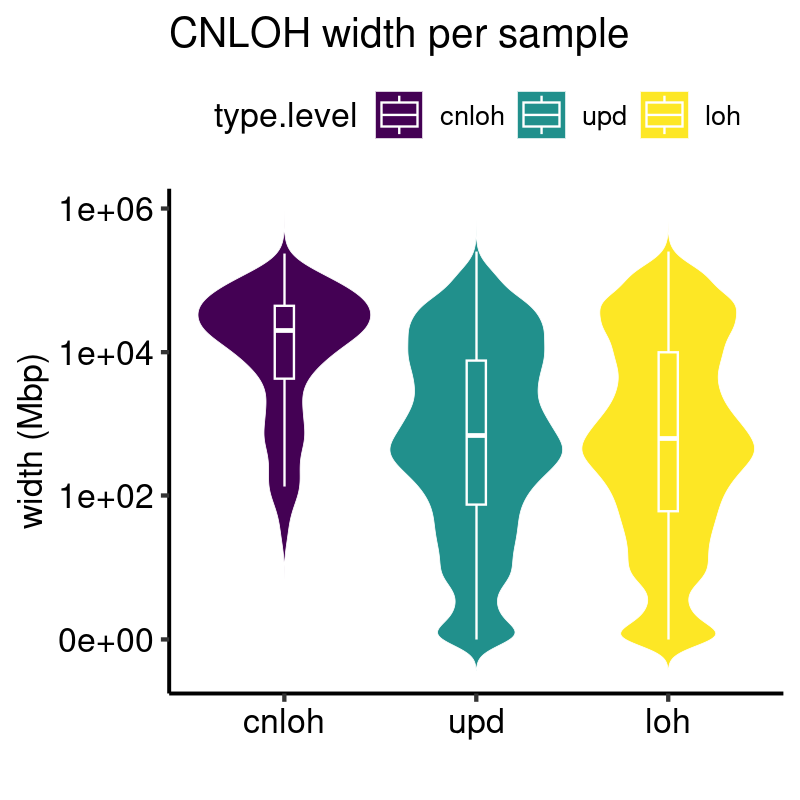

In [130]:
options(repr.plot.height = 4, repr.plot.width = 4, repr.plot.res = 200)
vp

## Fig. 4d
Fractional contribution of cnLOH, UPD, and other (not copy neutral LOH) to loss of heterozygosity

In [131]:
cnloh.ranges = readRDS("./data/cnloh/cnloh.ranges.rds")
loh.ranges = readRDS("./data/cnloh/loh.ranges.rds")
fake.cnloh.ranges = readRDS("./data/cnloh/fake.cnloh.ranges.rds")

## total number of events as a stacked barplot
loh.event.bp.dt = data.table(loh.type = ordered(c("loh", "upd", "mr"),
                                                levels = c("loh", "upd", "mr")),
                             segment.count = c(nrow(loh.ranges),
                                               nrow(fake.cnloh.ranges),
                                               nrow(cnloh.ranges)))

loh.event.bp = ggplot(loh.event.bp.dt, aes(x = 1, y = segment.count, fill = loh.type)) +
    geom_bar(stat = "identity", position = "fill") +
    scale_y_continuous(sec.axis = sec_axis(trans = ~ . * (loh.event.bp.dt[, sum(segment.count)]), name = "segment count")) +
    labs(x = "", y = "frac") +
    ggpubr::theme_pubr() +
    theme(axis.text.x = element_blank(), axis.title.x = element_blank()) +
    theme(legend.position = "right")

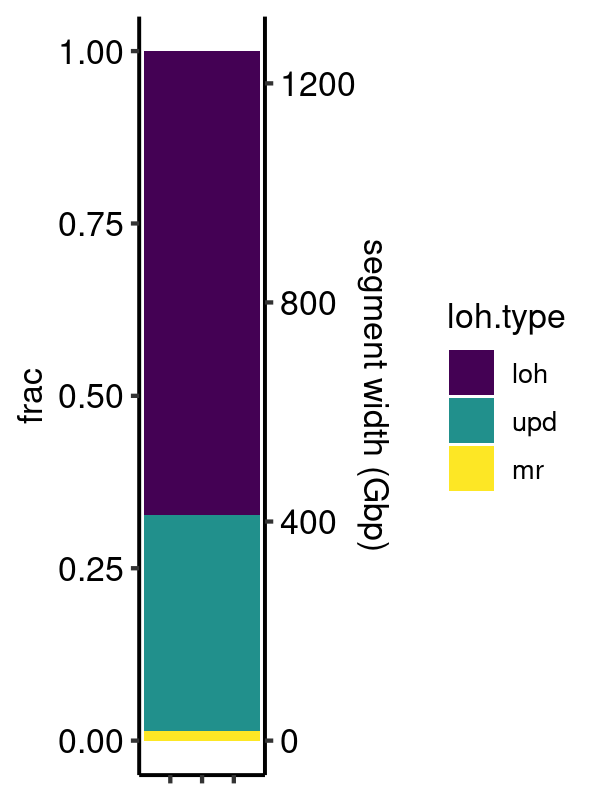

In [138]:
options(repr.plot.height = 4, repr.plot.width = 3, repr.plot.res = 200)
loh.event.bp

In [135]:
## total width of events as a stacked barplot
loh.width.bp.dt = data.table(loh.type = ordered(c("loh", "upd", "mr"),
                                                levels = c("loh", "upd", "mr")),
                             segment.width = c(sum(loh.ranges[, width / 1e9]),
                                               sum(fake.cnloh.ranges[, width / 1e9]),
                                               sum(cnloh.ranges[, width / 1e9])))

loh.event.bp = ggplot(loh.width.bp.dt, aes(x = 1, y = segment.width, fill = loh.type)) +
    geom_bar(stat = "identity", position = "fill") +
    scale_y_continuous(sec.axis = sec_axis(trans = ~ . * (loh.width.bp.dt[, sum(segment.width)]), name = "segment width (Gbp)")) +
    labs(x = "", y = "frac") +
    ggpubr::theme_pubr() +
    theme(axis.text.x = element_blank(), axis.title.x = element_blank()) +
    theme(legend.position = "right")

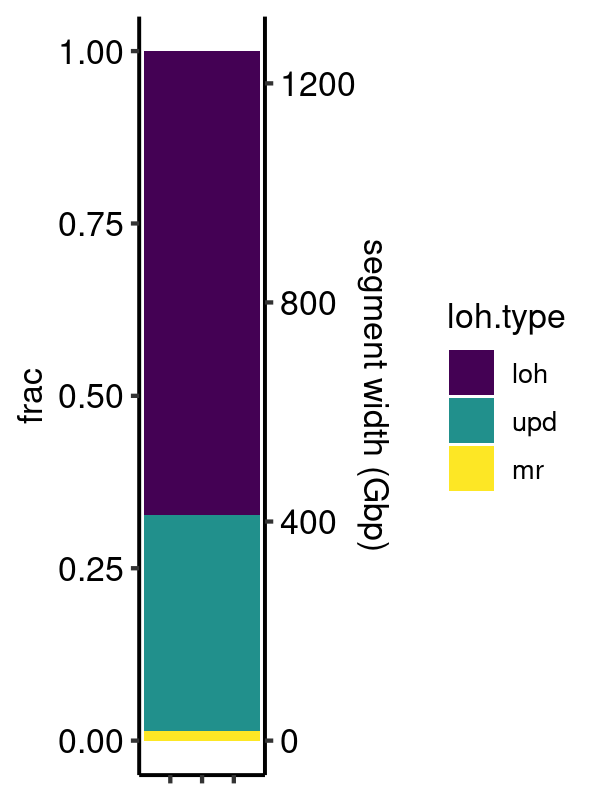

In [139]:
options(repr.plot.height = 4, repr.plot.width = 3, repr.plot.res = 200)
loh.event.bp

## Fig. 4f
Benchmarking detection of NAHR-associated loose ends

In [141]:
lp.nahr.sv.dt = readRDS("./data/nahr/lp.nahr.sv.dt")
sim.dt = readRDS("./data/benchmarking/sim.samples.dt.rds")

lp.nahr.sv.dt[, purity := sim.dt[pair, purity]]

pt = ggplot(lp.nahr.sv.dt[purity > 0.5, ], aes(x = n.cncp.gs, y = n.cncp)) +
    geom_point(alpha = 0.5) +
    labs(x = "true number of NAHR breakends", y = "estimated number of NAHR breakends") +
    geom_smooth(method='lm', formula = y ~ x) +
    ggpubr::stat_cor(method = "pearson", label.x = 15, label.y = 10) +
    ggpubr::theme_pubr()

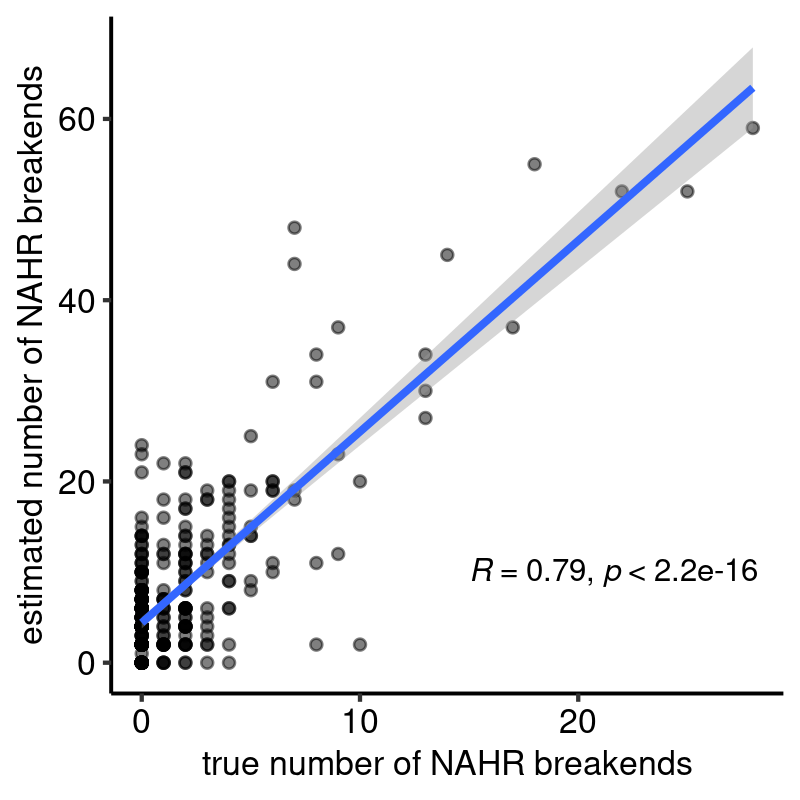

In [142]:
options(repr.plot.height = 4, repr.plot.width = 4, repr.plot.res = 200)
pt

## Fig. 4g
Comparison of putative NAHR rates among SRS junctions and loose ends

In [144]:
big.nahr.dt = readRDS("./data/nahr/lrs.srs.full.big.nahr.dt.rds")
big.nahr.pt.dt = readRDS("./data/nahr/lrs.srs.full.big.nahr.pt.dt.rds")

pt = ggplot(big.nahr.pt.dt, aes(x = germline.or.somatic, y = frac)) +
    geom_bar(stat = "identity") +
    geom_errorbar(aes(ymin = ci.lower,ymax = ci.upper), width = 0.2, position = position_dodge(0.9)) +
    facet_grid(cols = vars(breakend.type)) +
    labs(x = "breakend type", y = "frac putative NAHR") +
    ylim(0, 1) +
    ggpubr::theme_pubr()


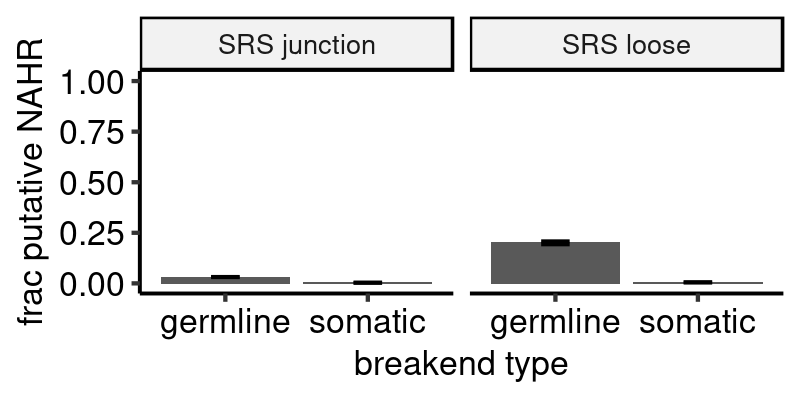

In [147]:
options(repr.plot.height = 2, repr.plot.width = 4, repr.plot.res = 200)
pt

## Fig. 4h
Comparison of NAHR rates among nanopore (LRS) junctions, SRS junctions, and SRS loose ends in long read validation cohort.

In [152]:
pt.dt = readRDS("./data/nahr/ont.srs.full.nahr.dt.rds") ## all the breakends
nahr.pt.dt = readRDS("./data/nahr/ont.srs.nahr.pt.dt.rds")

pt = ggplot(nahr.pt.dt, aes(x = germline.or.somatic, y = frac)) +
    geom_bar(stat = "identity") +
    geom_errorbar(aes(ymin = ci.lower,ymax = ci.upper), width = 0.2, position = position_dodge(0.9)) +
    facet_grid(cols = vars(platform)) +
    labs(x = "breakend type", y = "frac putative NAHR") +
    ylim(0, 1) +
    ggpubr::theme_pubr()

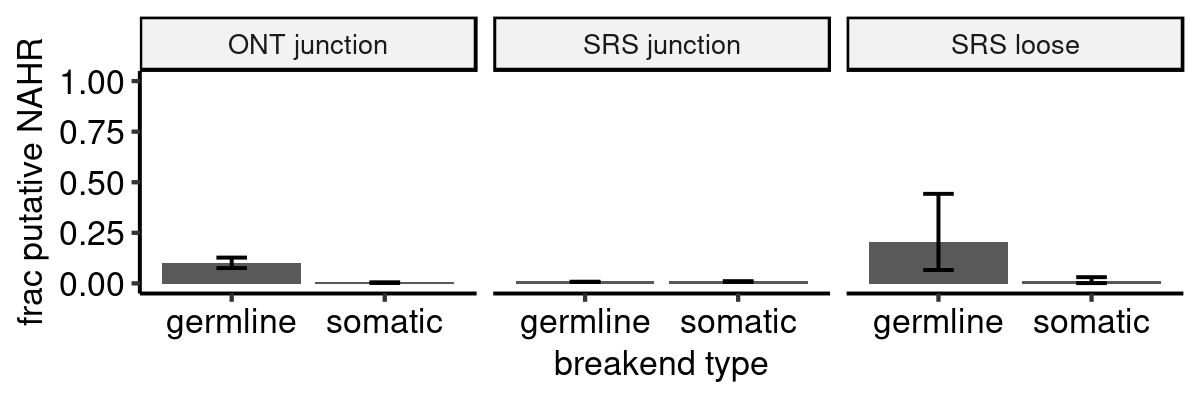

In [153]:
options(repr.plot.height = 2, repr.plot.width = 6, repr.plot.res = 200)
pt

# Figure 5
T2T extrapolation

## Fig. 5b
Heatmap (zoomed out version of the whole genome, as well as CN-unmappable only zoomed in)

### Zoomed out genome-wide heatmap (left)

In [163]:
big.tiles = readRDS("./data/t2t/big.tiles.rds")
overall.pt.dt = readRDS("./data/t2t/heatmap.dt.10mbp.rds")

ht_opt$message = FALSE ## turn off warnings

smat = sparseMatrix(i = overall.pt.dt[, as.numeric(as.character(bin1))],
                    j = overall.pt.dt[, as.numeric(as.character(bin2))],
                    x = overall.pt.dt[, log10(count)],
                    dims = c(length(big.tiles), length(big.tiles)),
                    index1 = TRUE)

mat = as.matrix(smat)

pal1 = RColorBrewer::brewer.pal(11, "BrBG")
pal2 = colorRampPalette(pal1)(24)
names(pal2) = names(seqlengths(big.tiles))

ha = ComplexHeatmap::HeatmapAnnotation(
    chr = as.character(seqnames(big.tiles)),
    col = list(chr = pal2)
)

col_fun = colorRamp2(c(0,
                       quantile(overall.pt.dt[, log10(count)], 0.9),
                       quantile(overall.pt.dt[, log10(count)], 0.9),
                       quantile(overall.pt.dt[, log10(count)], 0.999)),
                     c("white", "white", "pink", "red"))

split = values(big.tiles)[, "cnu.frac"] >= 0.1

op = ComplexHeatmap::Heatmap(matrix = mat, cluster_columns = FALSE, cluster_rows = FALSE,
                             cluster_row_slices = FALSE, cluster_column_slices = FALSE,
                             column_split = split, row_split = split,
                             col = col_fun,
                             use_raster = TRUE,
                             top_annotation = ha)

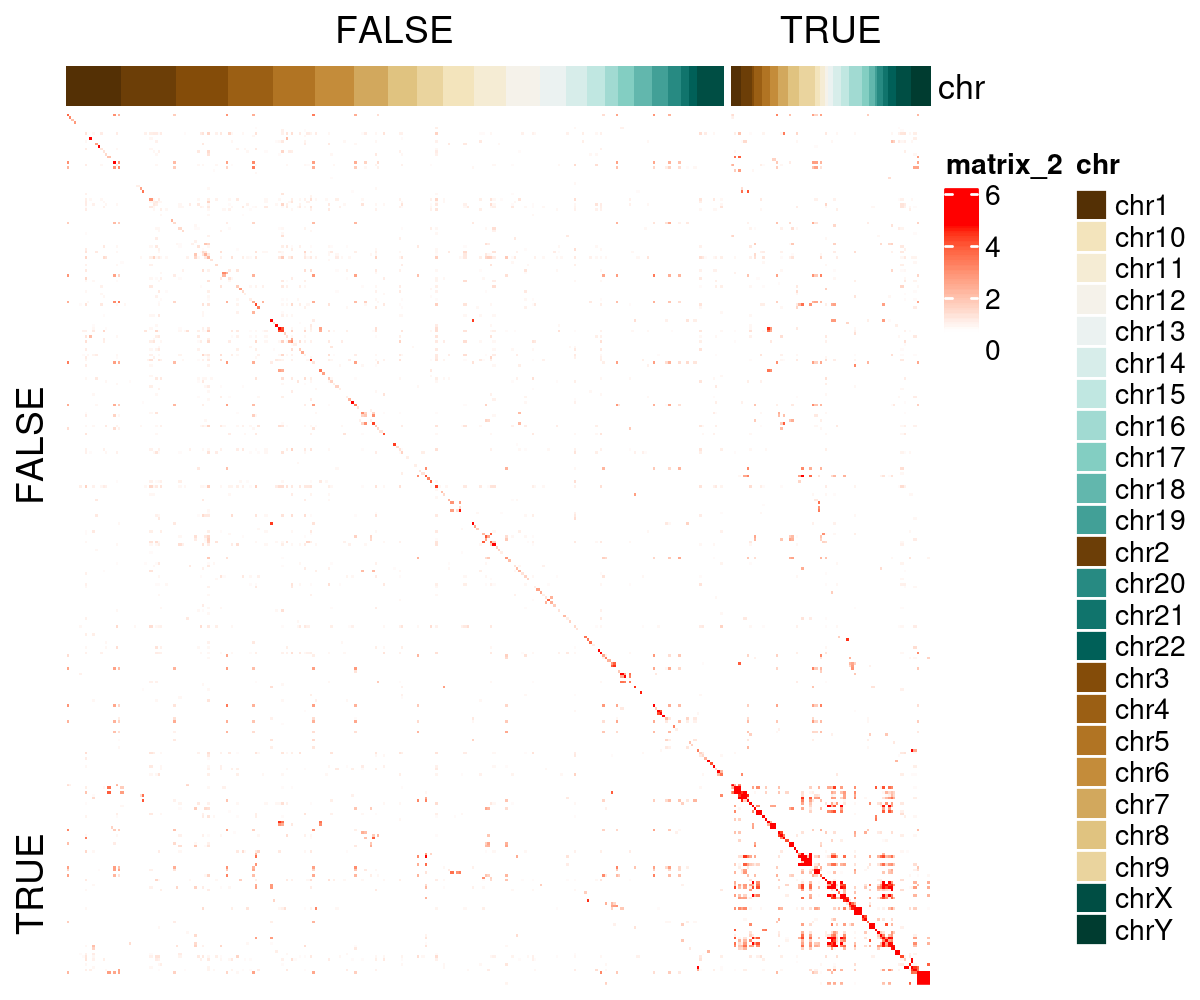

In [165]:
options(repr.plot.height = 5, repr.plot.width = 6, repr.plot.res = 200)
op

### Zoomed-in CN-unmappable heatmap (right)

In [169]:
unmappable.tiles = readRDS("./data/t2t/unmappable.tiles.rds")
overall.pt.dt = readRDS("./data/t2t/heatmap.dt.1mbp.rds")

ht_opt$message = FALSE ## turn off warnings

smat = sparseMatrix(i = overall.pt.dt[, bin1.remapped],
                    j = overall.pt.dt[, bin2.remapped],
                    x = overall.pt.dt[, log10(count)],
                    dims = c(length(unmappable.tiles), length(unmappable.tiles)),
                    index1 = TRUE)

mat = as.matrix(smat)

pal1 = RColorBrewer::brewer.pal(11, "BrBG")
pal2 = colorRampPalette(pal1)(24)
names(pal2) = names(seqlengths(unmappable.tiles))

ha = HeatmapAnnotation(
    chr = as.character(seqnames(unmappable.tiles)),
    col = list(chr = pal2)
)

op = ComplexHeatmap::Heatmap(matrix = mat, cluster_columns = FALSE, cluster_rows = FALSE,
                             cluster_row_slices = FALSE, cluster_column_slices = FALSE,
                             column_split = NULL, row_split = NULL,
                             col = col_fun,
                             use_raster = TRUE,
                             top_annotation = ha)

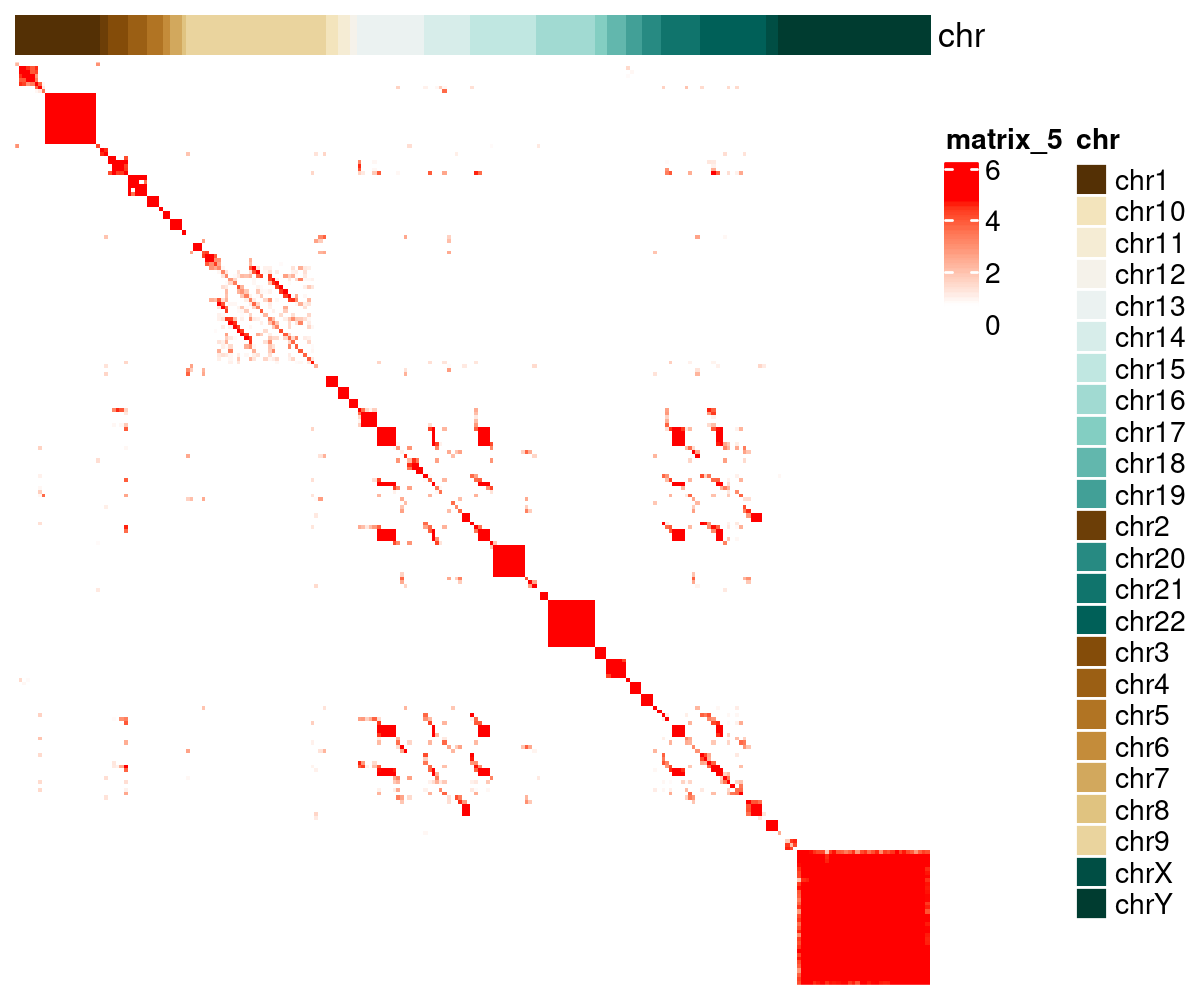

In [171]:
options(repr.plot.height = 5, repr.plot.width = 6, repr.plot.res = 200)
op

## Fig. 5c
Bar plot of eligible NAHR sites between CN mappable (CNM) and CN unmappable (CNU)

In [180]:
bp.dt = readRDS("./data/t2t/small.bins.bp.dt.for.barplot.rds")
bp.dt[, ":="(label = ifelse(bin1.mappable, 
                            ifelse(bin2.mappable, "CNUxCNU", "CNUxCNM"), 
                            ifelse(bin2.mappable, "CNUxCNM", "CNMxCNM")))]

bp = ggplot(bp.dt, aes(x = 1, y = V1, fill = label)) +
    geom_bar(stat = "identity", position = "fill") +
    labs(y = "fraction of homologous sites") +
    ggpubr::theme_pubr() +
    theme(legend.position = "right")

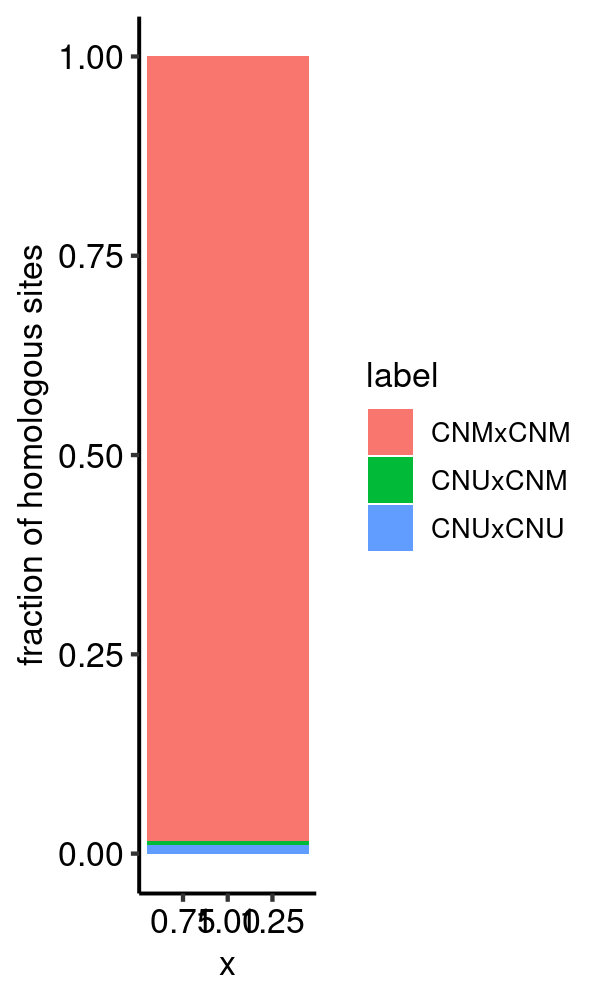

In [181]:
options(repr.plot.height = 5, repr.plot.width = 3, repr.plot.res = 200)
bp

## Fig. 5d
Final alluvial plot where we estimate the number of missing SRS rearrangements.

In [186]:
bs.alluvial.dt = fread("./data/t2t/5c.alluvial.txt", sep = ",", header = FALSE, skip = 1)
setnames(bs.alluvial.dt, c("location", "homology", "detected", "mappable", "fraction"))

## set colors
bs.alluvial.dt[, color.level := ordered(paste(ifelse(mappable == "no", "unmappable", "mappable"), 
                                              ifelse(homology == "no", "non-NAHR", "NAHR")), 
                                        levels = c("unmappable NAHR", 
                                                   "unmappable non-NAHR", 
                                                   "mappable NAHR", 
                                                   "mappable non-NAHR"))]

## levels
bs.alluvial.dt[, location.level := factor(location, c("CNU", "CNM"))]
bs.alluvial.dt[, homology.level := factor(ifelse(homology == "yes", "putative HR/MR", "non-nahr"), c("putative HR/MR", "non-nahr"))]
bs.alluvial.dt[, detected.level := factor(detected, c("no", "yes"))]
bs.alluvial.dt[, mapped.level := factor(mappable, c("no", "yes"))]

alluv.pt = ggplot(bs.alluvial.dt[order(mapped.level)][order(detected.level)][order(homology.level)][order(location.level)], aes(axis1 = location.level, axis2 = homology.level, axis3 = detected.level,y = fraction)) +
    ggalluvial::geom_alluvium(aes(fill = color.level), knot.pos = 0.3, width = 0, reverse = FALSE) +
    ggalluvial::geom_stratum(width = 0.4, reverse = FALSE, alpha = 0.5, color = "black") +
    geom_text(stat = "stratum", aes(label = after_stat(stratum)), reverse = FALSE, alpha = 1) +
    labs(y = "estimated fraction of breakends") +
    ggpubr::theme_pubr() +
    theme(legend.position = "right")


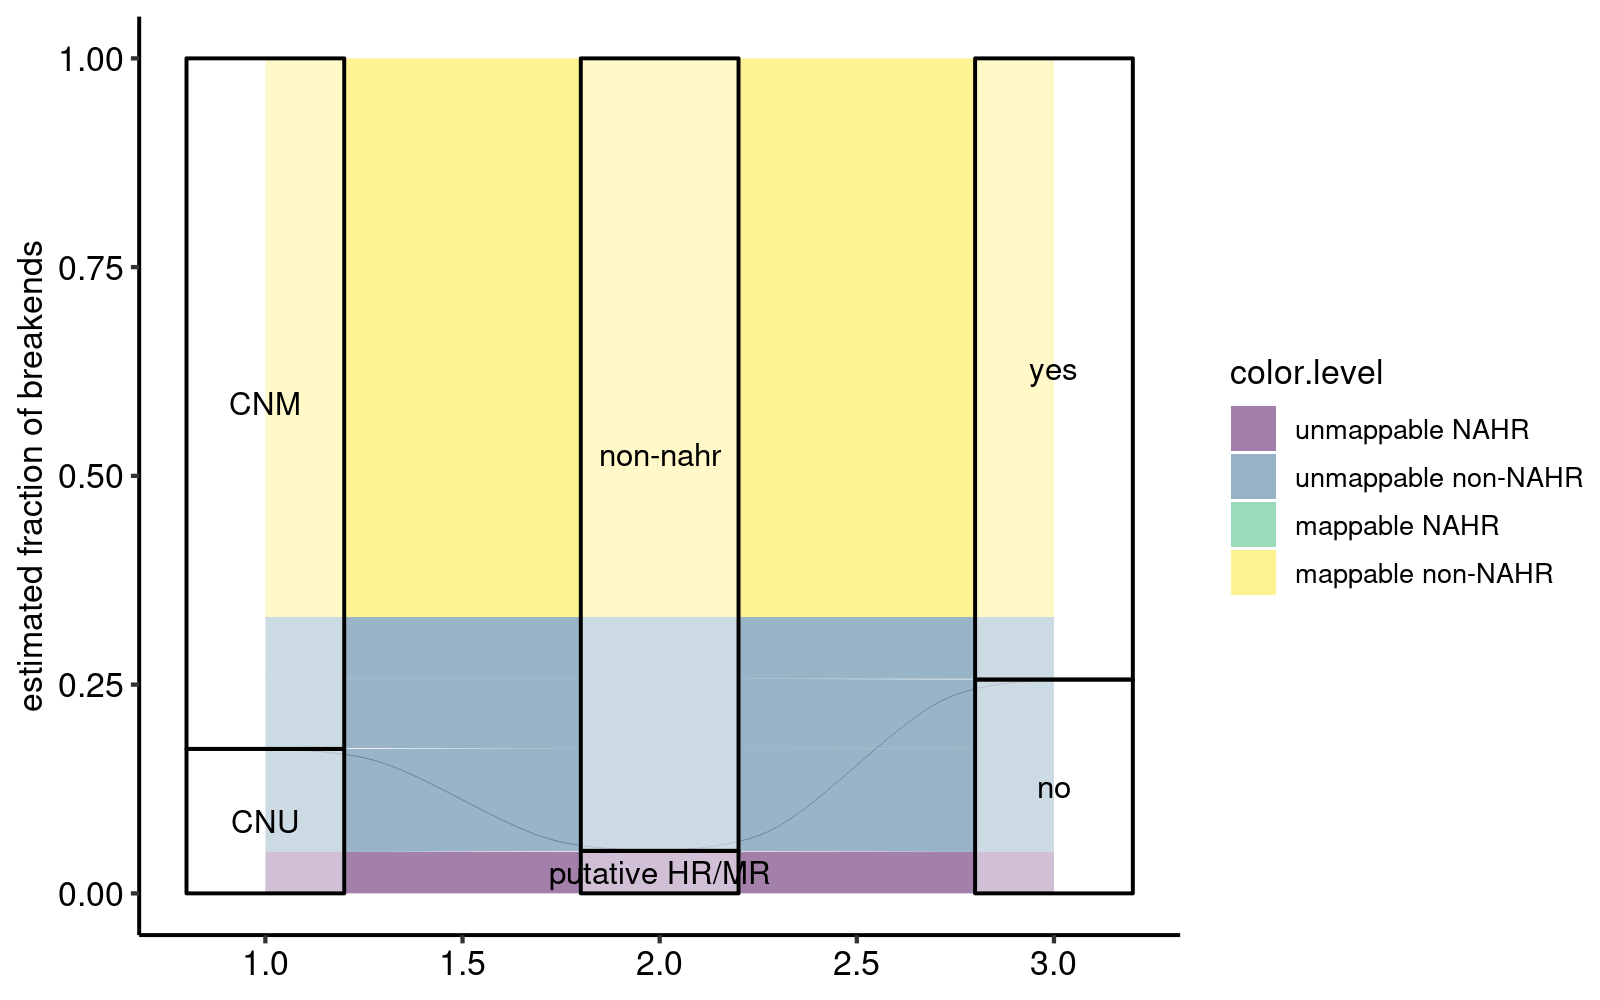

In [187]:
options(repr.plot.height = 5, repr.plot.width = 8, repr.plot.res = 200)
alluv.pt

In [ ]:
https://weillcornell.zoom.us/meeting/register/tJ0lc-iorT8iG9Vb7-TeWJWrhKwi5b67srdA